# Lab Exercise: High-Frequency Arbitrage in Fragmented Markets

**Deadline:** 9th of December 23:59 CET

**Submission:** Email to francisco.merlos@six-group.com with title: "Arbitrage study in BME | Your name"

In [1]:
# Import necessary libraries for data processing and analysis
import pandas as pd
import numpy as np
import os
from pathlib import Path
from glob import glob
import warnings
warnings.filterwarnings('ignore')

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Set pandas display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


## 1. Context: The Fragmented Market

In modern European equity markets, liquidity is **fragmented**. The same stock (ISIN) trades simultaneously on the primary exchange (BME) and various Multilateral Trading Facilities (MTFs) like CBOE, Turquoise, and Aquis.

Due to this fragmentation, temporary price discrepancies occur. A stock might be offered for sale at €10.00 on Turquoise while a buyer is bidding €10.01 on BME. A High-Frequency Trader (HFT) can profit from this by buying low and selling high instantaneously.

However, these opportunities are fleeting. The "theoretical" profit you see in a snapshot might disappear by the time your order reaches the exchange due to **latency**.

### The Mission

You have been hired as a Quantitative Researcher at a proprietary trading firm. Your boss has given you a dataset of high-resolution market data and asked you to answer three critical questions:

1. **Do arbitrage opportunities still exist in Spanish equities?**
2. **What is the maximum theoretical profit** (assuming 0 latency)?
3. **The "Latency Decay" Curve:** How quickly does this profit vanish as our trading system gets slower (from 0µs to 100ms)?

## 2. Data Specifications

You are provided with a `DATA_BIG/` folder containing subfolders for specific trading dates. Inside, you will find three types of compressed CSV files for various instruments.

**Note:** You can also find a `DATA_SMALL` folder that you can use to test quickly without needing to run the simulation over all the data.

### File Naming Convention

The naming pattern for all three file types (QTE, STS, TRD) is:

```
<type>_<session>_<isin>_<ticker>_<mic>_<part>.csv.gz
```

| Field | Description |
|-------|-------------|
| **type** | QTE, TRD, or STS |
| **session** | Trading date (YYYY-MM-DD) |
| **isin** | Cross-venue **ISIN** (International Securities Identification Number) |
| **ticker** | Venue-specific trading symbol (distinguishes multiple books for the same ISIN on the same MIC) |
| **mic** | Market Identifier Code (MIC, e.g., XMAD) |
| **part** | Integer part number. Assume it is always 1 for simplicity. |

### Order Book Identity and Join Key

A single **order book identity** is defined by the tuple:

```
(session, isin, mic, ticker)
```

This identity is the **key used to join** corresponding QTE, TRD, and STS data belonging to the same book.

### File Types

1. **QTE (Quotes/Snapshots):** Represents the state of the order book (up to 10 levels deep).
   - `epoch`: Timestamp in microseconds (UTC).
   - `px_bid_0`, `px_ask_0`: Best Bid and Best Ask prices.
   - `qty_bid_0`, `qty_ask_0`: Available volume at the best price.
   - *Note: Columns exist for levels 0-9.*

2. **STS (Trading Status):** Updates on the market phase (e.g., Open, Auction, Closed).
   - `epoch`: Timestamp.
   - `market_trading_status`: An integer code representing the state.

3. **TRD (Trades):** Represents the transactions. Not needed for this exercise.

### CRITICAL: Vendor Data Definitions

Real-world financial data is rarely clean. The data vendor has provided the following specifications. **Ignoring these will result in massive errors in your P&L calculation.**

#### A. "Magic Numbers" (Special Price Codes)

The vendor uses specific high-value constants to indicate non-tradable states (e.g., Market Orders during auctions). **These are NOT real prices.** If you treat 999,999 as a valid bid, your algorithm will assume you can sell for a million euros.

| Value | Meaning | Action Required |
|-------|---------|----------------|
| 666666.666 | Unquoted/Unknown | **Discard** |
| 999999.999 | Market Order (At Best) | **Discard** |
| 999999.989 | At Open Order | **Discard** |
| 999999.988 | At Close Order | **Discard** |
| 999999.979 | Pegged Order | **Discard** |
| 999999.123 | Unquoted/Unknown | **Discard** |

#### B. Market Status Codes

You can only trade when the market is in **Continuous Trading**. If you trade during an Auction, a Halt, or Pre-Open, your order will not execute immediately. A snapshot is only valid/addressable if the STS for that venue is one of these codes:

| Venue | Continuous Trading Code |
|-------|------------------------|
| AQUIS | 5308427 |
| BME | 5832713, 5832756 |
| CBOE | 12255233 |
| TURQUOISE | 7608181 |

## 3. Implementation Guide

You are encouraged to use AI tools (ChatGPT, Claude, etc.) to generate the Python/Pandas code. However, **you** are responsible for the logic and the financial validity of the results.

### Step 1: Data Ingestion & Cleaning

- Write a function to load the QTE and STS files for a given ISIN.
- **Task:** Ensure you are using only valid prices
- **Task:** Ensure you are only looking at addressable orderbooks

In [2]:
# ============================================================================
# STEP 1: DATA INGESTION & CLEANING
# ============================================================================
# This step discovers all ISINs in DATA_BIG and loads QTE (quotes) and STS 
# (trading status) files for each ISIN across all venues.
# ============================================================================

# Define the base data directory and trading session
DATA_DIR = 'DATA_BIG'
SESSION = '2025-11-07'

# Define venues (Market Identifier Codes) we need to process
VENUES = ['BME', 'CBOE', 'TURQUOISE', 'AQUIS']

# Define "magic numbers" that represent invalid/non-tradable prices
# These are special codes used by the vendor to indicate non-executable states
INVALID_PRICES = [
    666666.666,  # Unquoted/Unknown
    999999.999,  # Market Order (At Best)
    999999.989,  # At Open Order
    999999.988,  # At Close Order
    999999.979,  # Pegged Order
    999999.123   # Unquoted/Unknown
]

# Define valid market trading status codes for continuous trading per venue
# Only orderbooks in continuous trading are "addressable" (can be traded)
VALID_STATUS_CODES = {
    'AQUIS': [5308427],
    'BME': [5832713, 5832756],
    'CBOE': [12255233],
    'TURQUOISE': [7608181]
}

def discover_all_isins(data_dir=DATA_DIR, session=SESSION, venues=VENUES):
    """
    Discovers all unique ISINs across all venues by scanning QTE files.
    
    In fragmented markets, the same ISIN trades on multiple venues. This function
    scans all venue folders to build a comprehensive list of all available instruments.
    
    Returns:
        set: Unique ISINs found across all venues
    """
    isins = set()
    
    # Scan each venue folder for QTE files
    for venue in venues:
        venue_folder = f"{data_dir}/{venue}_{session}"
        
        if not os.path.exists(venue_folder):
            print(f"Warning: Venue folder {venue_folder} not found. Skipping.")
            continue
        
        # Find all QTE files in this venue
        # File pattern: QTE_<session>_<isin>_<ticker>_<mic>_<part>.csv.gz
        qte_files = glob(f"{venue_folder}/QTE_*.csv.gz")
        
        # Extract ISIN from each filename (3rd component after splitting by '_')
        for file_path in qte_files:
            filename = os.path.basename(file_path)
            parts = filename.split('_')
            if len(parts) >= 3:
                isin = parts[2]  # ISIN is the 3rd component
                isins.add(isin)
    
    print(f"Discovered {len(isins)} unique ISINs across all venues")
    return sorted(isins)

def load_qte_sts_for_isin(isin, data_dir=DATA_DIR, session=SESSION, venues=VENUES):
    """
    Loads all QTE (quotes) and STS (trading status) files for a given ISIN across all venues.
    
    Market Microstructure Context:
    - QTE files contain orderbook snapshots showing bid/ask prices and quantities
    - STS files contain market phase information (Open, Continuous Trading, Auction, etc.)
    - We need both to determine: 1) What prices are available, 2) Whether we can actually trade
    
    Args:
        isin: The ISIN identifier (e.g., 'ES0113900J37')
        data_dir: Base directory containing venue folders
        session: Trading date (YYYY-MM-DD)
        venues: List of venue codes to process
    
    Returns:
        tuple: (qte_dataframes_dict, sts_dataframes_dict)
            - qte_dataframes_dict: {venue: DataFrame} mapping
            - sts_dataframes_dict: {venue: DataFrame} mapping
    """
    qte_dfs = {}
    sts_dfs = {}
    
    # Process each venue
    for venue in venues:
        venue_folder = f"{data_dir}/{venue}_{session}"
        
        if not os.path.exists(venue_folder):
            continue
        
        # Find QTE and STS files for this ISIN in this venue
        # Note: There may be multiple tickers for the same ISIN on the same venue
        qte_pattern = f"{venue_folder}/QTE_{session}_{isin}_*_*.csv.gz"
        sts_pattern = f"{venue_folder}/STS_{session}_{isin}_*_*.csv.gz"
        
        qte_files = glob(qte_pattern)
        sts_files = glob(sts_pattern)
        
        # Load all QTE files for this venue (may have multiple orderbooks)
        if qte_files:
            # Load and concatenate all QTE files for this ISIN+venue combination
            qte_list = []
            for qte_file in qte_files:
                try:
                    df_qte = pd.read_csv(qte_file, sep=';', compression='gzip')
                    # Add metadata columns to identify the orderbook
                    filename = os.path.basename(qte_file)
                    parts = filename.split('_')
                    if len(parts) >= 5:
                        df_qte['ticker'] = parts[3]  # Extract ticker from filename
                        df_qte['mic'] = parts[4]     # Extract MIC from filename
                        df_qte['venue'] = venue      # Add venue identifier
                    qte_list.append(df_qte)
                except Exception as e:
                    print(f"Error loading {qte_file}: {e}")
                    continue
            
            if qte_list:
                # Combine all QTE files for this venue
                qte_combined = pd.concat(qte_list, ignore_index=True)
                qte_dfs[venue] = qte_combined
                print(f"  {venue}: Loaded {len(qte_combined)} QTE records")
        
        # Load all STS files for this venue
        if sts_files:
            sts_list = []
            for sts_file in sts_files:
                try:
                    df_sts = pd.read_csv(sts_file, sep=';', compression='gzip')
                    filename = os.path.basename(sts_file)
                    parts = filename.split('_')
                    if len(parts) >= 5:
                        df_sts['ticker'] = parts[3]
                        df_sts['mic'] = parts[4]
                        df_sts['venue'] = venue
                    sts_list.append(df_sts)
                except Exception as e:
                    print(f"Error loading {sts_file}: {e}")
                    continue
            
            if sts_list:
                sts_combined = pd.concat(sts_list, ignore_index=True)
                sts_dfs[venue] = sts_combined
                print(f"  {venue}: Loaded {len(sts_combined)} STS records")
    
    return qte_dfs, sts_dfs

# ============================================================================
# EXECUTE: Discover all ISINs and load QTE/STS files
# ============================================================================

print("=" * 70)
print("STEP 1: DISCOVERING ISINs AND LOADING QTE/STS FILES")
print("=" * 70)

# Discover all unique ISINs in the dataset
all_isins = discover_all_isins()
print(f"\nTotal unique ISINs found: {len(all_isins)}")
print(f"First 10 ISINs: {all_isins[:10]}\n")

# Load QTE and STS files for each ISIN
# Note: We'll process all ISINs, but for large datasets, you might want to 
# process in batches or use lazy loading strategies
print("\nLoading QTE and STS files for all ISINs...")
print("-" * 70)

# Store all loaded data in a dictionary structure
# Structure: {isin: {'qte': {venue: df}, 'sts': {venue: df}}}
all_data = {}

for idx, isin in enumerate(all_isins, 1):
    print(f"\n[{idx}/{len(all_isins)}] Processing ISIN: {isin}")
    qte_dfs, sts_dfs = load_qte_sts_for_isin(isin)
    
    if qte_dfs or sts_dfs:
        all_data[isin] = {
            'qte': qte_dfs,
            'sts': sts_dfs
        }
    else:
        print(f"  Warning: No QTE/STS files found for {isin}")

print("\n" + "=" * 70)
print(f"STEP 1 COMPLETE: Loaded data for {len(all_data)} ISINs")
print("=" * 70)


STEP 1: DISCOVERING ISINs AND LOADING QTE/STS FILES
Discovered 195 unique ISINs across all venues

Total unique ISINs found: 195
First 10 ISINs: ['ARP125991090', 'AU000000BKY0', 'BRBBDCACNPR8', 'BRPETRACNOR9', 'BRPETRACNPR6', 'BRUSIMACNOR3', 'DE000FA5G8E7', 'DE000FA5HCF1', 'DE000FA5HGL0', 'DE000FA5HH03']


Loading QTE and STS files for all ISINs...
----------------------------------------------------------------------

[1/195] Processing ISIN: ARP125991090
  BME: Loaded 48 QTE records
  BME: Loaded 7 STS records

[2/195] Processing ISIN: AU000000BKY0
  BME: Loaded 1256 QTE records
  BME: Loaded 7 STS records
  CBOE: Loaded 928 QTE records
  CBOE: Loaded 7 STS records
  AQUIS: Loaded 1135 QTE records
  AQUIS: Loaded 3 STS records

[3/195] Processing ISIN: BRBBDCACNPR8
  BME: Loaded 25 QTE records
  BME: Loaded 4 STS records

[4/195] Processing ISIN: BRPETRACNOR9
  BME: Loaded 1324 QTE records
  BME: Loaded 4 STS records

[5/195] Processing ISIN: BRPETRACNPR6
  BME: Loaded 1288 QTE recor

In [3]:
# ============================================================================
# DATA CLEANING & PREPARATION: Unified Function Following Reference Pattern
# ============================================================================
# This unified function combines cleaning and timestamp preparation following
# the structure from 'Working with microsecond timeseries.py' (clean_hft_data_preserve_all).
# 
# The function:
# 1. Sorts by ['epoch', 'sequence'] FIRST (before any operations)
# 2. Applies nanosecond trick to create unique timestamps
# 3. Sets timestamp index
# 4. Merges STS status and filters invalid prices/status codes
# ============================================================================

def clean_and_prepare_qte_data(qte_df, sts_df=None, venue=None, 
                                invalid_prices=INVALID_PRICES, 
                                valid_status_codes=VALID_STATUS_CODES):
    """
    Unified function that cleans and prepares QTE data following the reference pattern.
    
    This function follows the structure from 'clean_hft_data_preserve_all' in the reference:
    1. Sorts strictly by epoch and sequence (if available)
    2. Applies nanosecond trick to handle duplicate epochs
    3. Sets unique timestamp index
    4. Merges STS trading status (if available)
    5. Filters invalid prices and non-continuous trading periods
    
    Market Microstructure Context:
    - Multiple orderbook snapshots can occur at the same microsecond
    - Sequence column preserves the order of events within the same microsecond
    - We can only trade during Continuous Trading (not during auctions/halts)
    - Magic numbers represent non-executable orders (market orders, pegged orders, etc.)
    - These must be filtered out to avoid false arbitrage signals
    
    Args:
        qte_df: DataFrame with QTE (quote) data (must have 'epoch' column)
        sts_df: Optional DataFrame with STS (trading status) data
        venue: Optional venue identifier (BME, CBOE, etc.) for status code filtering
        invalid_prices: List of magic numbers to filter out
        valid_status_codes: Dict mapping venue to valid status codes
    
    Returns:
        DataFrame with unique timestamp index, cleaned and filtered
    """
    if qte_df.empty:
        return qte_df
    
    # Make a copy to avoid modifying original
    df = qte_df.copy()
    
    # ========================================================================
    # STEP 1: Sort strictly by epoch and sequence (if available)
    # ========================================================================
    # This is CRITICAL: We must sort by ['epoch', 'sequence'] BEFORE any
    # time-based operations. The sequence column preserves the order of events
    # within the same microsecond, which is essential for accurate time ordering.
    # 
    # Market Microstructure: When multiple orderbook updates happen at the
    # same microsecond, the sequence number indicates the order in which they
    # occurred. This is crucial for maintaining chronological accuracy.
    sort_cols = ['epoch']
    if 'sequence' in df.columns:
        sort_cols.append('sequence')
        # Note: QTE files include sequence column to preserve event order
    else:
        # If sequence is missing, document why (shouldn't happen for QTE files)
        print("    Warning: 'sequence' column not found in QTE data. Using epoch only for sorting.")
    
    df = df.sort_values(by=sort_cols, ascending=[True] * len(sort_cols))
    
    # ========================================================================
    # STEP 2: Apply the "Nanosecond Trick" to create unique timestamps
    # ========================================================================
    # Convert epoch to datetime (microseconds)
    temp_ts = pd.to_datetime(df['epoch'], unit='us')
    
    # The "Nanosecond Trick" (from reference: clean_hft_data_preserve_all)
    # groupby().cumcount() numbers items in a group: 0, 1, 2, 3...
    # We group by 'epoch' to find snapshots happening at the same time.
    # We treat that count as nanoseconds to create unique timestamps.
    offset_ns = df.groupby('epoch').cumcount()
    
    # Safety check: ensure we don't exceed 1000 snapshots per microsecond
    # (nanoseconds go from 0-999, so 1000 would overflow to next microsecond)
    max_offset = offset_ns.max() if len(offset_ns) > 0 else 0
    if max_offset >= 1000:
        raise Exception(f"Too many snapshots at the same microsecond. Max offset: {max_offset}")
    
    # Create the final High-Resolution Timestamp
    # Base Time (microseconds) + Offset (nanoseconds)
    df['ts'] = temp_ts + pd.to_timedelta(offset_ns, unit='ns')
    
    # ========================================================================
    # STEP 3: Set timestamp as index
    # ========================================================================
    # This creates a unique timestamp index that can be used for merge_asof,
    # pivot operations, and time-based lookups
    df.set_index('ts', inplace=True)
    
    # ========================================================================
    # STEP 4: Merge STS trading status (if available)
    # ========================================================================
    # Process STS data if available to filter by market trading status
    if sts_df is not None and not sts_df.empty:
        # Prepare STS data for merging
        sts_clean = sts_df.copy()
        sts_clean['ts'] = pd.to_datetime(sts_clean['epoch'], unit='us')
        
        # Sort STS by timestamp for merge_asof
        sts_clean = sts_clean.sort_values('ts').reset_index(drop=True)
        
        # Get valid status codes for this venue
        venue_valid_codes = valid_status_codes.get(venue, []) if venue else []
        
        # Merge STS status with QTE using merge_asof (backward direction)
        # This assigns the most recent market status to each quote
        # Direction='backward' ensures we only use status that was known at quote time
        # (avoids look-ahead bias)
        df = pd.merge_asof(
            df.reset_index(),  # Reset index temporarily for merge_asof
            sts_clean[['ts', 'market_trading_status']],
            on='ts',
            direction='backward'
        )
        
        # Filter: Keep only rows where market status is in continuous trading
        if venue_valid_codes:
            df = df[df['market_trading_status'].isin(venue_valid_codes)].copy()
        
        # Drop the market_trading_status column (no longer needed)
        df = df.drop(columns=['market_trading_status'], errors='ignore')
        
        # Set timestamp back as index
        df.set_index('ts', inplace=True)
    elif venue:
        # If no STS data but venue is specified, warn but continue
        print(f"    Warning: No STS data for {venue}, cannot filter by trading status")
    
    # ========================================================================
    # STEP 5: Filter out invalid prices (magic numbers)
    # ========================================================================
    # Check both bid and ask prices at level 0 (best bid/ask)
    price_columns = ['px_bid_0', 'px_ask_0']
    
    # Create a mask: True for rows with valid prices
    valid_price_mask = pd.Series(True, index=df.index)
    
    for col in price_columns:
        if col in df.columns:
            # Check if price is in the invalid prices list
            col_mask = ~df[col].isin(invalid_prices)
            valid_price_mask = valid_price_mask & col_mask
    
    # Apply the filter
    df = df[valid_price_mask].copy()
    
    return df

# ============================================================================
# EXECUTE: Clean all loaded QTE data
# ============================================================================

print("\n" + "=" * 70)
print("CLEANING & PREPARING QTE DATA: Filtering Invalid Prices, Non-Continuous Trading, and Creating Unique Timestamps")
print("=" * 70)

# Clean QTE data for each ISIN
cleaned_data = {}

for isin, data in all_data.items():
    print(f"\nCleaning and preparing data for ISIN: {isin}")
    qte_dfs = data.get('qte', {})
    sts_dfs = data.get('sts', {})
    
    cleaned_qte = {}
    
    for venue in qte_dfs.keys():
        qte_df = qte_dfs[venue]
        sts_df = sts_dfs.get(venue, pd.DataFrame())
        
        # Get original count
        original_count = len(qte_df)
        
        # Clean and prepare the data (unified function)
        qte_cleaned = clean_and_prepare_qte_data(qte_df, sts_df, venue)
        
        # Get cleaned count
        cleaned_count = len(qte_cleaned)
        removed_count = original_count - cleaned_count
        
        if original_count > 0:
            removal_pct = (removed_count / original_count) * 100
            print(f"  {venue}: {original_count:,} -> {cleaned_count:,} records "
                  f"({removed_count:,} removed, {removal_pct:.2f}%)")
        
        if cleaned_count > 0:
            cleaned_qte[venue] = qte_cleaned
    
    if cleaned_qte:
        cleaned_data[isin] = {
            'qte': cleaned_qte,
            'sts': sts_dfs  # STS data unchanged
        }

print("\n" + "=" * 70)
print(f"CLEANING & PREPARATION COMPLETE: Processed data for {len(cleaned_data)} ISINs")
print("=" * 70)

# Update all_data with cleaned and prepared version
all_data = cleaned_data



CLEANING & PREPARING QTE DATA: Filtering Invalid Prices, Non-Continuous Trading, and Creating Unique Timestamps

Cleaning and preparing data for ISIN: ARP125991090
  BME: 48 -> 22 records (26 removed, 54.17%)

Cleaning and preparing data for ISIN: AU000000BKY0
  BME: 1,256 -> 1,127 records (129 removed, 10.27%)
  CBOE: 928 -> 926 records (2 removed, 0.22%)
  AQUIS: 1,135 -> 1,132 records (3 removed, 0.26%)

Cleaning and preparing data for ISIN: BRBBDCACNPR8
  BME: 25 -> 20 records (5 removed, 20.00%)

Cleaning and preparing data for ISIN: BRPETRACNOR9
  BME: 1,324 -> 1,249 records (75 removed, 5.66%)

Cleaning and preparing data for ISIN: BRPETRACNPR6
  BME: 1,288 -> 1,245 records (43 removed, 3.34%)

Cleaning and preparing data for ISIN: BRUSIMACNOR3
  BME: 56 -> 54 records (2 removed, 3.57%)

Cleaning and preparing data for ISIN: DE000FA5G8E7
  BME: 340 -> 340 records (0 removed, 0.00%)

Cleaning and preparing data for ISIN: DE000FA5HCF1
  BME: 652 -> 652 records (0 removed, 0.00%)


In [4]:
# ============================================================================
# NOTE: Timestamp Preparation is Now Integrated
# ============================================================================
# The timestamp preparation (nanosecond trick) is now integrated into the
# unified clean_and_prepare_qte_data() function in the previous cell.
# This ensures proper sorting by ['epoch', 'sequence'] before any operations.
# 
# The data in all_data is already cleaned and prepared with unique timestamps.
# ============================================================================

# Verification: Check that timestamps are unique
print("\n" + "=" * 70)
print("VERIFICATION: Checking Timestamp Uniqueness")
print("=" * 70)

unique_check_passed = True
for isin, data in all_data.items():
    qte_dfs = data.get('qte', {})
    for venue, qte_df in qte_dfs.items():
        if not qte_df.empty:
            is_unique = qte_df.index.is_unique
            if not is_unique:
                print(f"  WARNING: {isin} on {venue} has non-unique timestamps!")
                unique_check_passed = False

if unique_check_passed:
    print("  ✓ All timestamps are unique across all ISINs and venues")
else:
    print("  ✗ Some timestamps are not unique - please check the data")

# Note: The old prepare_qte_timestamps function has been removed as it's now
# integrated into clean_and_prepare_qte_data() following the reference pattern.

# ============================================================================
# DEMONSTRATION: Nanosecond Trick for Duplicate Epochs
# ============================================================================
# Similar to the reference notebook, we demonstrate how the nanosecond trick
# handles multiple snapshots at the same microsecond
# ============================================================================

print("\n" + "=" * 70)
print("DEMONSTRATION: Handling Duplicate Epochs with Nanosecond Trick")
print("=" * 70)

# Find an example with duplicate epochs (one that needed the nanosecond trick)
example_found = False
example_isin = None
example_venue = None
example_df = None

for isin, data in all_data.items():
    qte_dfs = data.get('qte', {})
    for venue, qte_df in qte_dfs.items():
        if not qte_df.empty:
            # Check for duplicate epochs (before preparation, but we can check the index)
            # Look for timestamps with nanosecond offsets (indicating duplicates were resolved)
            bursts = qte_df[qte_df.index.nanosecond > 0]
            if not bursts.empty:
                example_isin = isin
                example_venue = venue
                example_df = qte_df
                example_found = True
                break
    if example_found:
        break

if example_found and example_df is not None:
    print(f"\n📊 Example: {example_isin} on {example_venue}")
    print(f"   Total snapshots: {len(example_df):,}")
    
    # Check for duplicate epochs (like in reference notebook lines 1-3)
    # We need to check the original epoch column to see duplicates
    duplicates = example_df.duplicated(subset='epoch', keep=False).sum()
    print(f"   Found {duplicates} snapshots sharing the same microsecond (duplicate epochs)")
    
    # Find a specific burst example
    bursts = example_df[example_df.index.nanosecond > 0]
    if not bursts.empty:
        print(f"   Found {len(bursts)} snapshots with nanosecond offsets (collisions resolved)")
        
        # Get the first burst timestamp
        burst_ts = bursts.index[0]
        base_ts = burst_ts.replace(nanosecond=0)
        
        # Get all snapshots at this base timestamp (the "burst")
        burst_snapshots = example_df.loc[base_ts : base_ts + pd.Timedelta(nanoseconds=999)]
        
        print(f"\n💥 Example of a resolved collision (Look at the timestamps!):")
        print(f"   Base timestamp: {base_ts}")
        print(f"   Number of snapshots at this microsecond: {len(burst_snapshots)}")
        print(f"\n   All snapshots at this microsecond:")
        
        # Show relevant columns including sequence if available
        display_cols = ['epoch', 'px_bid_0', 'px_ask_0', 'qty_bid_0', 'qty_ask_0']
        if 'sequence' in burst_snapshots.columns:
            display_cols.insert(1, 'sequence')
        
        print(burst_snapshots[display_cols].to_string())
        
        print(f"\n   Note: Each snapshot has a unique timestamp index with nanosecond offsets")
        print(f"   This preserves the order (by sequence if available) while ensuring uniqueness")
    else:
        print("   No duplicate epochs found in this example")
else:
    print("\n⚠️  No examples with duplicate epochs found to demonstrate")





VERIFICATION: Checking Timestamp Uniqueness
  ✓ All timestamps are unique across all ISINs and venues

DEMONSTRATION: Handling Duplicate Epochs with Nanosecond Trick

📊 Example: AU000000BKY0 on BME
   Total snapshots: 1,127
   Found 105 snapshots sharing the same microsecond (duplicate epochs)
   Found 53 snapshots with nanosecond offsets (collisions resolved)

💥 Example of a resolved collision (Look at the timestamps!):
   Base timestamp: 2025-11-07 08:10:33.395695
   Number of snapshots at this microsecond: 2

   All snapshots at this microsecond:
                                          epoch  sequence  px_bid_0  px_ask_0  qty_bid_0  qty_ask_0
ts                                                                                                 
2025-11-07 08:10:33.395695000  1762503033395695       169    0.3160     0.319      69473    10000.0
2025-11-07 08:10:33.395695001  1762503033395695       170    0.3165     0.319      14272    10000.0

   Note: Each snapshot has a unique timest

In [5]:
# ============================================================================
# DESCRIPTIVE SUMMARY: Overview of Loaded Data
# ============================================================================
# This section creates a summary DataFrame showing key statistics about the
# downloaded data: venues, ISINs, record counts, etc.
# ============================================================================

print("\n" + "=" * 70)
print("DESCRIPTIVE SUMMARY OF LOADED DATA")
print("=" * 70)

# Initialize summary statistics
summary_data = []

# Analyze each ISIN
for isin, data in all_data.items():
    qte_dfs = data.get('qte', {})
    sts_dfs = data.get('sts', {})
    
    # Count records per venue for this ISIN
    for venue in VENUES:
        qte_count = len(qte_dfs.get(venue, pd.DataFrame()))
        sts_count = len(sts_dfs.get(venue, pd.DataFrame()))
        
        if qte_count > 0 or sts_count > 0:
            summary_data.append({
                'ISIN': isin,
                'Venue': venue,
                'QTE_Records': qte_count,
                'STS_Records': sts_count,
                'Total_Records': qte_count + sts_count
            })

# Create summary DataFrame
df_summary = pd.DataFrame(summary_data)

if len(df_summary) > 0:
    # Overall statistics
    print(f"\n📊 OVERALL STATISTICS:")
    print(f"   • Total unique ISINs: {df_summary['ISIN'].nunique()}")
    print(f"   • Total venue-ISIN combinations: {len(df_summary)}")
    print(f"   • Total QTE records: {df_summary['QTE_Records'].sum():,}")
    print(f"   • Total STS records: {df_summary['STS_Records'].sum():,}")
    print(f"   • Total records: {df_summary['Total_Records'].sum():,}")
    
    # Statistics by venue
    print(f"\n🏢 STATISTICS BY VENUE:")
    venue_stats = df_summary.groupby('Venue').agg({
        'ISIN': 'nunique',
        'QTE_Records': 'sum',
        'STS_Records': 'sum',
        'Total_Records': 'sum'
    }).rename(columns={'ISIN': 'Unique_ISINs'})
    venue_stats = venue_stats.sort_values('Total_Records', ascending=False)
    print(venue_stats.to_string())
    
    # Statistics by ISIN (top 10)
    print(f"\n📈 TOP 10 ISINs BY TOTAL RECORDS:")
    isin_stats = df_summary.groupby('ISIN').agg({
        'Venue': 'count',
        'QTE_Records': 'sum',
        'STS_Records': 'sum',
        'Total_Records': 'sum'
    }).rename(columns={'Venue': 'Num_Venues'})
    isin_stats = isin_stats.sort_values('Total_Records', ascending=False)
    print(isin_stats.head(10).to_string())
    
    # Venue coverage per ISIN
    print(f"\n🔗 VENUE COVERAGE:")
    venue_coverage = df_summary.groupby('ISIN')['Venue'].count()
    coverage_stats = venue_coverage.value_counts().sort_index()
    print("Number of venues per ISIN:")
    for num_venues, count in coverage_stats.items():
        print(f"   • {num_venues} venue(s): {count} ISIN(s)")
    
    # Statistics about duplicate epochs (nanosecond trick usage)
    print(f"\n⏱️  DUPLICATE EPOCHS STATISTICS (Nanosecond Trick Required):")
    duplicate_epoch_stats = []
    
    for isin, data in all_data.items():
        qte_dfs = data.get('qte', {})
        for venue, qte_df in qte_dfs.items():
            if not qte_df.empty:
                # Count snapshots with nanosecond offsets (indicating duplicate epochs)
                bursts = qte_df[qte_df.index.nanosecond > 0]
                num_bursts = len(bursts)
                
                if num_bursts > 0:
                    # Count unique epochs that had duplicates
                    burst_epochs = qte_df.loc[bursts.index, 'epoch'].unique()
                    num_duplicate_epochs = len(burst_epochs)
                    
                    # Find max number of snapshots at a single epoch
                    epoch_counts = qte_df.groupby('epoch').size()
                    max_snapshots_per_epoch = epoch_counts.max()
                    
                    duplicate_epoch_stats.append({
                        'ISIN': isin,
                        'Venue': venue,
                        'Snapshots_With_NS_Offset': num_bursts,
                        'Unique_Epochs_With_Duplicates': num_duplicate_epochs,
                        'Max_Snapshots_Per_Epoch': max_snapshots_per_epoch
                    })
    
    if duplicate_epoch_stats:
        df_dup_epochs = pd.DataFrame(duplicate_epoch_stats)
        total_dup_combinations = len(df_dup_epochs)
        total_snapshots_with_offset = df_dup_epochs['Snapshots_With_NS_Offset'].sum()
        total_dup_epochs = df_dup_epochs['Unique_Epochs_With_Duplicates'].sum()
        max_snapshots = df_dup_epochs['Max_Snapshots_Per_Epoch'].max()
        
        print(f"   • Venue-ISIN combinations with duplicate epochs: {total_dup_combinations}")
        print(f"   • Total snapshots requiring nanosecond offsets: {total_snapshots_with_offset:,}")
        print(f"   • Total unique epochs with duplicates: {total_dup_epochs:,}")
        print(f"   • Maximum snapshots at a single epoch: {max_snapshots}")
        print(f"\n   Top 5 by number of duplicate epochs:")
        top_5_dup = df_dup_epochs.nlargest(5, 'Unique_Epochs_With_Duplicates')
        print(top_5_dup[['ISIN', 'Venue', 'Unique_Epochs_With_Duplicates', 'Max_Snapshots_Per_Epoch']].to_string(index=False))
    else:
        print(f"   • No duplicate epochs found - all snapshots have unique microsecond timestamps")
    
    # Create a detailed summary DataFrame for display
    print(f"\n📋 DETAILED SUMMARY DATAFRAME (First 20 rows):")
    print(df_summary.head(20).to_string(index=False))
    
    # Store the summary DataFrame for later use
    print(f"\n✅ Summary DataFrame stored as 'df_summary' ({len(df_summary)} rows)")
    
else:
    print("⚠️  No data loaded. Please check Step 1 execution.")


# ============================================================================
# STATISTICS: Epochs Requiring Nanosecond Trick
# ============================================================================

print("\n" + "=" * 70)
print("STATISTICS: Epochs Requiring Nanosecond Trick")
print("=" * 70)

# Collect statistics about duplicate epochs
duplicate_stats = []

for isin, data in all_data.items():
    qte_dfs = data.get('qte', {})
    for venue, qte_df in qte_dfs.items():
        if not qte_df.empty:
            # Count snapshots with nanosecond offsets (indicating duplicate epochs were resolved)
            bursts = qte_df[qte_df.index.nanosecond > 0]
            num_bursts = len(bursts)
            
            if num_bursts > 0:
                # Count unique epochs that had duplicates
                burst_epochs = qte_df.loc[bursts.index, 'epoch'].unique()
                num_duplicate_epochs = len(burst_epochs)
                
                # Find max number of snapshots at a single epoch
                epoch_counts = qte_df.groupby('epoch').size()
                max_snapshots_per_epoch = epoch_counts.max()
                
                duplicate_stats.append({
                    'ISIN': isin,
                    'Venue': venue,
                    'Total_Snapshots': len(qte_df),
                    'Snapshots_With_NS_Offset': num_bursts,
                    'Unique_Epochs_With_Duplicates': num_duplicate_epochs,
                    'Max_Snapshots_Per_Epoch': max_snapshots_per_epoch
                })

if duplicate_stats:
    df_duplicate_stats = pd.DataFrame(duplicate_stats)
    
    print(f"\n📈 Summary of Epochs Requiring Nanosecond Trick:")
    print(f"   • Total venue-ISIN combinations with duplicate epochs: {len(df_duplicate_stats)}")
    print(f"   • Total snapshots requiring nanosecond offsets: {df_duplicate_stats['Snapshots_With_NS_Offset'].sum():,}")
    print(f"   • Total unique epochs with duplicates: {df_duplicate_stats['Unique_Epochs_With_Duplicates'].sum():,}")
    print(f"   • Maximum snapshots at a single epoch: {df_duplicate_stats['Max_Snapshots_Per_Epoch'].max()}")
    
    print(f"\n📋 Top 10 ISIN-Venue combinations by number of duplicate epochs:")
    top_duplicates = df_duplicate_stats.nlargest(10, 'Unique_Epochs_With_Duplicates')
    print(top_duplicates[['ISIN', 'Venue', 'Total_Snapshots', 'Unique_Epochs_With_Duplicates', 
                          'Max_Snapshots_Per_Epoch']].to_string(index=False))
    
    print(f"\n💡 Market Microstructure Context:")
    print(f"   Multiple orderbook snapshots at the same microsecond occur when:")
    print(f"   - Rapid orderbook updates happen faster than microsecond resolution")
    print(f"   - Market data feeds batch multiple updates together")
    print(f"   - High-frequency trading activity creates bursts of updates")
    print(f"   The nanosecond trick preserves all snapshots while maintaining chronological order")
else:
    print("\n✅ No duplicate epochs found - all snapshots have unique microsecond timestamps")



DESCRIPTIVE SUMMARY OF LOADED DATA

📊 OVERALL STATISTICS:
   • Total unique ISINs: 185
   • Total venue-ISIN combinations: 434
   • Total QTE records: 7,311,154
   • Total STS records: 2,374
   • Total records: 7,313,528

🏢 STATISTICS BY VENUE:
           Unique_ISINs  QTE_Records  STS_Records  Total_Records
Venue                                                           
BME                 185      3529996         1125        3531121
CBOE                 89      1519860          632        1520492
AQUIS                96      1359160          423        1359583
TURQUOISE            64       902138          194         902332

📈 TOP 10 ISINs BY TOTAL RECORDS:
              Num_Venues  QTE_Records  STS_Records  Total_Records
ISIN                                                             
ES0177542018           4      1115460           26        1115486
ES0113900J37           4       586156           23         586179
ES0113211835           4       333681           22         333703


### Step 2: Create the "Consolidated Tape"

- To detect arbitrage, you need to compare prices across venues *at the exact same time*.
- **Task:** Create a single DataFrame where the index is the timestamp, and the columns represent the Best Bid and Best Ask for **every** venue (BME, XMAD, CBOE, etc.).

In [6]:
# ============================================================================
# STEP 2: CREATE THE CONSOLIDATED TAPE
# ============================================================================
# The consolidated tape combines orderbook snapshots from all venues into
# a single time-indexed DataFrame, allowing us to compare prices across
# venues at the exact same timestamp.
#
# Market Microstructure Context:
# - Financial markets are asynchronous: updates happen at different times
#   on different venues
# - To detect arbitrage, we need to know what prices are available on ALL
#   venues at the SAME moment in time
# - We use "Last Traded Price" (LTP) logic: if a venue hasn't updated at
#   time T, we use the last known price from that venue
# - Forward fill (ffill) propagates the last known bid/ask forward until
#   a new update arrives
# ============================================================================

def create_consolidated_tape_for_isin(isin, cleaned_data_dict):
    """
    Creates a consolidated tape for a single ISIN across all venues.
    
    The consolidated tape is a DataFrame where:
    - Index: Timestamp (nanosecond precision)
    - Columns: Best Bid and Best Ask for each venue
      (e.g., 'BME_bid', 'BME_ask', 'CBOE_bid', 'CBOE_ask', etc.)
    
    Market Microstructure Context:
    - Each venue updates its orderbook independently
    - We need to see all venues' prices at the same timestamp to detect
      arbitrage opportunities
    - Forward fill ensures that if BME updates at t=100µs and CBOE updates
      at t=105µs, we can still compare prices at t=102µs using BME's last
      known price
    
    Args:
        isin: The ISIN identifier
        cleaned_data_dict: Dictionary with structure {isin: {'qte': {venue: df}}}
    
    Returns:
        DataFrame with timestamp index and columns for each venue's bid/ask
    """
    if isin not in cleaned_data_dict:
        return pd.DataFrame()
    
    qte_dfs = cleaned_data_dict[isin].get('qte', {})
    
    if not qte_dfs:
        return pd.DataFrame()
    
    # ========================================================================
    # STEP 1: Extract Best Bid and Ask from Each Venue
    # ========================================================================
    # For each venue, we extract px_bid_0 (best bid) and px_ask_0 (best ask)
    # along with their quantities. We also preserve the venue identifier
    # so we can distinguish between venues after concatenation.
    
    venue_data_list = []
    
    for venue, qte_df in qte_dfs.items():
        if qte_df.empty:
            continue
        
        # Extract only the columns we need: best bid/ask prices and quantities
        # Market Microstructure: We use level 0 (best bid/ask) because these
        # are the prices at which we can immediately execute trades
        venue_subset = qte_df[['px_bid_0', 'px_ask_0', 'qty_bid_0', 'qty_ask_0']].copy()
        
        # Add venue identifier as a column (needed for pivot operation)
        venue_subset['venue'] = venue
        
        # Rename columns to include venue prefix for clarity
        # This will help us identify which venue each price comes from
        venue_subset = venue_subset.rename(columns={
            'px_bid_0': 'bid',
            'px_ask_0': 'ask',
            'qty_bid_0': 'bid_qty',
            'qty_ask_0': 'ask_qty'
        })
        
        venue_data_list.append(venue_subset)
    
    if not venue_data_list:
        return pd.DataFrame()
    
    # ========================================================================
    # STEP 2: Combine All Venues into Single DataFrame
    # ========================================================================
    # Concatenate all venue data into one long DataFrame, preserving the
    # timestamp index from each venue's cleaned QTE data.
    # 
    # Market Microstructure: This creates a unified timeline where we can
    # see all orderbook updates from all venues in chronological order.
    
    tape_full = pd.concat(venue_data_list)
    
    # Sort by timestamp to ensure chronological order
    # This is critical: we need events in time order for forward fill to work
    tape_full.sort_index(inplace=True)
    
    # ========================================================================
    # STEP 3: Create Separate DataFrames for Bid and Ask
    # ========================================================================
    # We need to pivot bid and ask separately because pivot can only handle
    # one value column at a time. We'll create two pivoted DataFrames and
    # then combine them.
    
    # Pivot bids: creates columns like 'BME', 'CBOE', etc. with bid prices
    # Market Microstructure: Each column represents the best bid price
    # available on that venue at each timestamp
    tape_bid_pivot = tape_full.pivot(columns='venue', values='bid')
    
    # Pivot asks: creates columns like 'BME', 'CBOE', etc. with ask prices
    # Market Microstructure: Each column represents the best ask price
    # available on that venue at each timestamp
    tape_ask_pivot = tape_full.pivot(columns='venue', values='ask')
    
    # ========================================================================
    # STEP 4: Forward Fill to Propagate Last Known Prices
    # ========================================================================
    # Forward fill (ffill) is the key operation that makes the consolidated
    # tape work. It propagates the last known price forward until a new
    # update arrives.
    #
    # Market Microstructure: This implements the "Last Traded Price" (LTP)
    # logic. If BME updates at t=100µs and CBOE updates at t=105µs, then:
    # - At t=100µs: BME has new price, CBOE still has old price
    # - At t=101-104µs: Both venues have their last known prices
    # - At t=105µs: CBOE updates, BME still has price from t=100µs
    #
    # This allows us to compare prices across venues at ANY timestamp,
    # not just when all venues update simultaneously.
    
    tape_bid_ffill = tape_bid_pivot.ffill()
    tape_ask_ffill = tape_ask_pivot.ffill()
    
    # ========================================================================
    # STEP 5: Rename Columns to Include Bid/Ask Suffix
    # ========================================================================
    # Rename columns to make it clear which is bid and which is ask
    # This creates columns like 'BME_bid', 'BME_ask', 'CBOE_bid', etc.
    
    tape_bid_ffill.columns = [f'{venue}_bid' for venue in tape_bid_ffill.columns]
    tape_ask_ffill.columns = [f'{venue}_ask' for venue in tape_ask_ffill.columns]
    
    # ========================================================================
    # STEP 6: Combine Bid and Ask into Final Consolidated Tape
    # ========================================================================
    # Join the bid and ask DataFrames together to create the final consolidated
    # tape with all venue prices in one place.
    
    consolidated_tape = pd.concat([tape_bid_ffill, tape_ask_ffill], axis=1)
    
    # Sort columns alphabetically for consistency (optional, but makes output cleaner)
    consolidated_tape = consolidated_tape.sort_index(axis=1)
    
    return consolidated_tape

# ============================================================================
# EXECUTE: Create Consolidated Tape for All ISINs
# ============================================================================

print("\n" + "=" * 70)
print("STEP 2: CREATING CONSOLIDATED TAPE FOR ALL ISINs")
print("=" * 70)

# Store consolidated tapes for all ISINs
consolidated_tapes = {}

# Process each ISIN
for idx, isin in enumerate(all_data.keys(), 1):
    print(f"\n[{idx}/{len(all_data)}] Creating consolidated tape for ISIN: {isin}")
    
    # Create consolidated tape for this ISIN
    tape = create_consolidated_tape_for_isin(isin, all_data)
    
    if not tape.empty:
        consolidated_tapes[isin] = tape
        
        # Display summary statistics
        num_venues = len([col for col in tape.columns if '_bid' in col])
        num_updates = len(tape)
        
        # Count non-null values to see data coverage
        bid_cols = [col for col in tape.columns if '_bid' in col]
        ask_cols = [col for col in tape.columns if '_ask' in col]
        
        total_bid_updates = tape[bid_cols].notna().sum().sum() if bid_cols else 0
        total_ask_updates = tape[ask_cols].notna().sum().sum() if ask_cols else 0
        
        print(f"  ✓ Created tape with {num_venues} venue(s)")
        print(f"  ✓ Total timestamps: {num_updates:,}")
        print(f"  ✓ Total bid updates: {total_bid_updates:,}")
        print(f"  ✓ Total ask updates: {total_ask_updates:,}")
        
        # Show first few rows as example
        if idx <= 3:  # Only show for first 3 ISINs to avoid clutter
            print(f"\n  Sample of consolidated tape (first 5 rows):")
            print(tape.head().to_string())
    else:
        print(f"  ⚠️  No data available for consolidated tape")

print("\n" + "=" * 70)
print(f"STEP 2 COMPLETE: Created consolidated tapes for {len(consolidated_tapes)} ISINs")
print("=" * 70)



STEP 2: CREATING CONSOLIDATED TAPE FOR ALL ISINs

[1/185] Creating consolidated tape for ISIN: ARP125991090
  ✓ Created tape with 1 venue(s)
  ✓ Total timestamps: 22
  ✓ Total bid updates: 22
  ✓ Total ask updates: 22

  Sample of consolidated tape (first 5 rows):
                            BME_ask  BME_bid
ts                                          
2025-11-07 10:30:21.189794     5.15      4.6
2025-11-07 10:31:41.122120     5.10      4.6
2025-11-07 10:31:47.718999     5.10      4.6
2025-11-07 10:32:17.364304     5.05      4.6
2025-11-07 10:33:10.577872     5.05      4.6

[2/185] Creating consolidated tape for ISIN: AU000000BKY0
  ✓ Created tape with 3 venue(s)
  ✓ Total timestamps: 3,163
  ✓ Total bid updates: 9,467
  ✓ Total ask updates: 9,462

  Sample of consolidated tape (first 5 rows):
                            AQUIS_ask  AQUIS_bid  BME_ask  BME_bid  CBOE_ask  CBOE_bid
ts                                                                                    
2025-11-07 08:00:17.

In [7]:
# ============================================================================
# VERIFICATION: Check Consolidated Tape Structure
# ============================================================================
# This verification demonstrates the consolidated tape structure using an
# ISIN that has multiple venues and uses the nanosecond trick (has duplicate
# epochs that were resolved).
# ============================================================================

if consolidated_tapes:
    # Find an ISIN with multiple venues (3-4) that also uses nanosecond trick
    # Market Microstructure: We want to demonstrate the consolidated tape
    # with a realistic example that shows:
    # 1. Multiple venues trading the same ISIN (fragmented market)
    # 2. Nanosecond trick usage (multiple snapshots at same microsecond)
    
    print("\n" + "=" * 70)
    print("VERIFICATION: Consolidated Tape Structure")
    print("=" * 70)
    
    # Search for an ISIN with multiple venues and nanosecond trick usage
    example_isin = None
    example_tape = None
    max_venues = 0
    has_nanosecond_trick = False
    
    # Priority: Find ISIN with 4 venues that uses nanosecond trick
    # Known examples from Step 1: ES0113900J37, ES0177542018 have 4 venues
    candidate_isins = ['ES0113900J37', 'ES0177542018', 'ES0113211835', 'ES0140609019']
    
    for candidate_isin in candidate_isins:
        if candidate_isin in consolidated_tapes:
            tape = consolidated_tapes[candidate_isin]
            num_venues = len([col for col in tape.columns if '_bid' in col])
            
            # Check if this ISIN uses nanosecond trick (has timestamps with nanosecond offsets)
            if candidate_isin in all_data:
                qte_dfs = all_data[candidate_isin].get('qte', {})
                for venue, qte_df in qte_dfs.items():
                    if not qte_df.empty:
                        # Check for nanosecond offsets (indicating nanosecond trick was used)
                        bursts = qte_df[qte_df.index.nanosecond > 0]
                        if not bursts.empty and num_venues >= 3:
                            example_isin = candidate_isin
                            example_tape = tape
                            max_venues = num_venues
                            has_nanosecond_trick = True
                            break
                if has_nanosecond_trick:
                    break
    
    # If no candidate found, find any ISIN with 3+ venues
    if example_isin is None:
        for isin, tape in consolidated_tapes.items():
            num_venues = len([col for col in tape.columns if '_bid' in col])
            if num_venues >= 3 and num_venues > max_venues:
                example_isin = isin
                example_tape = tape
                max_venues = num_venues
    
    # If still no candidate, use first available
    if example_isin is None and consolidated_tapes:
        example_isin = list(consolidated_tapes.keys())[0]
        example_tape = consolidated_tapes[example_isin]
        max_venues = len([col for col in example_tape.columns if '_bid' in col])
    
    if example_isin and example_tape is not None:
        print(f"\n📊 Example ISIN: {example_isin}")
        print(f"   Number of venues: {max_venues}")
        print(f"   Uses nanosecond trick: {has_nanosecond_trick}")
        
        # Get venue names
        bid_cols = [col for col in example_tape.columns if '_bid' in col]
        venues = [col.replace('_bid', '') for col in bid_cols]
        print(f"   Venues: {', '.join(venues)}")
        
        print(f"\n📐 Consolidated Tape Structure:")
        print(f"   Shape: {example_tape.shape} (rows, columns)")
        print(f"   Index Type: {type(example_tape.index).__name__}")
        print(f"   Index Unique: {example_tape.index.is_unique} ✓")
        print(f"   Total Timestamps: {len(example_tape):,}")
        
        print(f"\n📋 Column Names ({len(example_tape.columns)} total):")
        for col in sorted(example_tape.columns):
            non_null_count = example_tape[col].notna().sum()
            pct_coverage = (non_null_count / len(example_tape)) * 100
            print(f"   • {col:15s} ({non_null_count:>8,} values, {pct_coverage:>5.1f}% coverage)")
        
        print(f"\n📊 Sample Data (first 10 rows):")
        print(example_tape.head(10).to_string())
        
        # Demonstrate nanosecond trick if applicable
        if has_nanosecond_trick and example_isin in all_data:
            print(f"\n⏱️  Nanosecond Trick Demonstration:")
            qte_dfs = all_data[example_isin].get('qte', {})
            
            # Find a venue with nanosecond offsets
            for venue, qte_df in qte_dfs.items():
                if not qte_df.empty:
                    bursts = qte_df[qte_df.index.nanosecond > 0]
                    if not bursts.empty:
                        # Get first burst example
                        burst_ts = bursts.index[0]
                        base_ts = burst_ts.replace(nanosecond=0)
                        
                        # Get all snapshots at this base timestamp
                        burst_snapshots = qte_df.loc[base_ts : base_ts + pd.Timedelta(nanoseconds=999)]
                        
                        print(f"\n   Example from {venue} venue:")
                        print(f"   Base timestamp: {base_ts}")
                        print(f"   Number of snapshots at this microsecond: {len(burst_snapshots)}")
                        print(f"   These snapshots were resolved using nanosecond offsets:")
                        
                        # Show relevant columns
                        display_cols = ['epoch', 'px_bid_0', 'px_ask_0']
                        if 'sequence' in burst_snapshots.columns:
                            display_cols.insert(1, 'sequence')
                        
                        print(burst_snapshots[display_cols].to_string())
                        break
        
        print(f"\n💡 Market Microstructure Context:")
        print(f"   • Each row represents a point in time where at least one venue")
        print(f"     updated its orderbook")
        print(f"   • Forward fill (ffill) ensures that all venues' last known prices")
        print(f"     are available at every timestamp")
        print(f"   • This enables cross-venue price comparison for arbitrage detection")
        print(f"   • The nanosecond trick preserves chronological order when multiple")
        print(f"     snapshots occur at the same microsecond")
        
        # Show example of forward fill in action
        print(f"\n🔄 Forward Fill Example:")
        # Find a row where one venue has a value and another doesn't initially
        bid_cols = [col for col in example_tape.columns if '_bid' in col]
        if len(bid_cols) >= 2:
            # Find first non-null value for first venue
            first_venue_col = bid_cols[0]
            first_non_null_idx = example_tape[first_venue_col].first_valid_index()
            
            if first_non_null_idx is not None:
                # Show a few rows around this point
                start_idx = example_tape.index.get_loc(first_non_null_idx)
                end_idx = min(start_idx + 5, len(example_tape))
                sample_range = example_tape.iloc[start_idx:end_idx]
                
                print(f"   Showing how forward fill propagates prices:")
                print(f"   (First non-null value for {first_venue_col} at {first_non_null_idx})")
                print(sample_range[bid_cols].to_string())
    else:
        print("\n⚠️  No consolidated tapes available for verification.")
else:
    print("\n⚠️  No consolidated tapes created. Please check Step 1 execution.")



VERIFICATION: Consolidated Tape Structure

📊 Example ISIN: ES0113900J37
   Number of venues: 4
   Uses nanosecond trick: True
   Venues: AQUIS, BME, CBOE, TURQUOISE

📐 Consolidated Tape Structure:
   Shape: (585262, 8) (rows, columns)
   Index Type: DatetimeIndex
   Index Unique: True ✓
   Total Timestamps: 585,262

📋 Column Names (8 total):
   • AQUIS_ask       ( 585,259 values, 100.0% coverage)
   • AQUIS_bid       ( 585,260 values, 100.0% coverage)
   • BME_ask         ( 585,118 values, 100.0% coverage)
   • BME_bid         ( 585,118 values, 100.0% coverage)
   • CBOE_ask        ( 585,138 values, 100.0% coverage)
   • CBOE_bid        ( 585,138 values, 100.0% coverage)
   • TURQUOISE_ask   ( 585,261 values, 100.0% coverage)
   • TURQUOISE_bid   ( 585,262 values, 100.0% coverage)

📊 Sample Data (first 10 rows):
                               AQUIS_ask  AQUIS_bid  BME_ask  BME_bid  CBOE_ask  CBOE_bid  TURQUOISE_ask  TURQUOISE_bid
ts                                                     

## **EXTRA** Visualization: Exploring Consolidated Tape Data

Before proceeding to Step 3 (Signal Generation), let's visualize the consolidated tape data to understand price dynamics, spreads, and potential arbitrage opportunities across venues. These visualizations will help us understand the market microstructure and identify patterns in the data.

**(Estimado Francisco, en estos graficos a proposito he dejado la duplicidad de oportunidades de arbitraje puesto que todavia no hemos llegado al Step 3 en el cual nos intruias eliminarlos, los muestro a propósito porque creo que son muy ilustrativos a la hora de remarcar la importancia de lidiar con estas duplicidades)**

VISUALIZATION 1: Price Evolution Across Venues

Selected ISINs for visualization: ['ES0105025003', 'ES0105027009', 'AU000000BKY0']


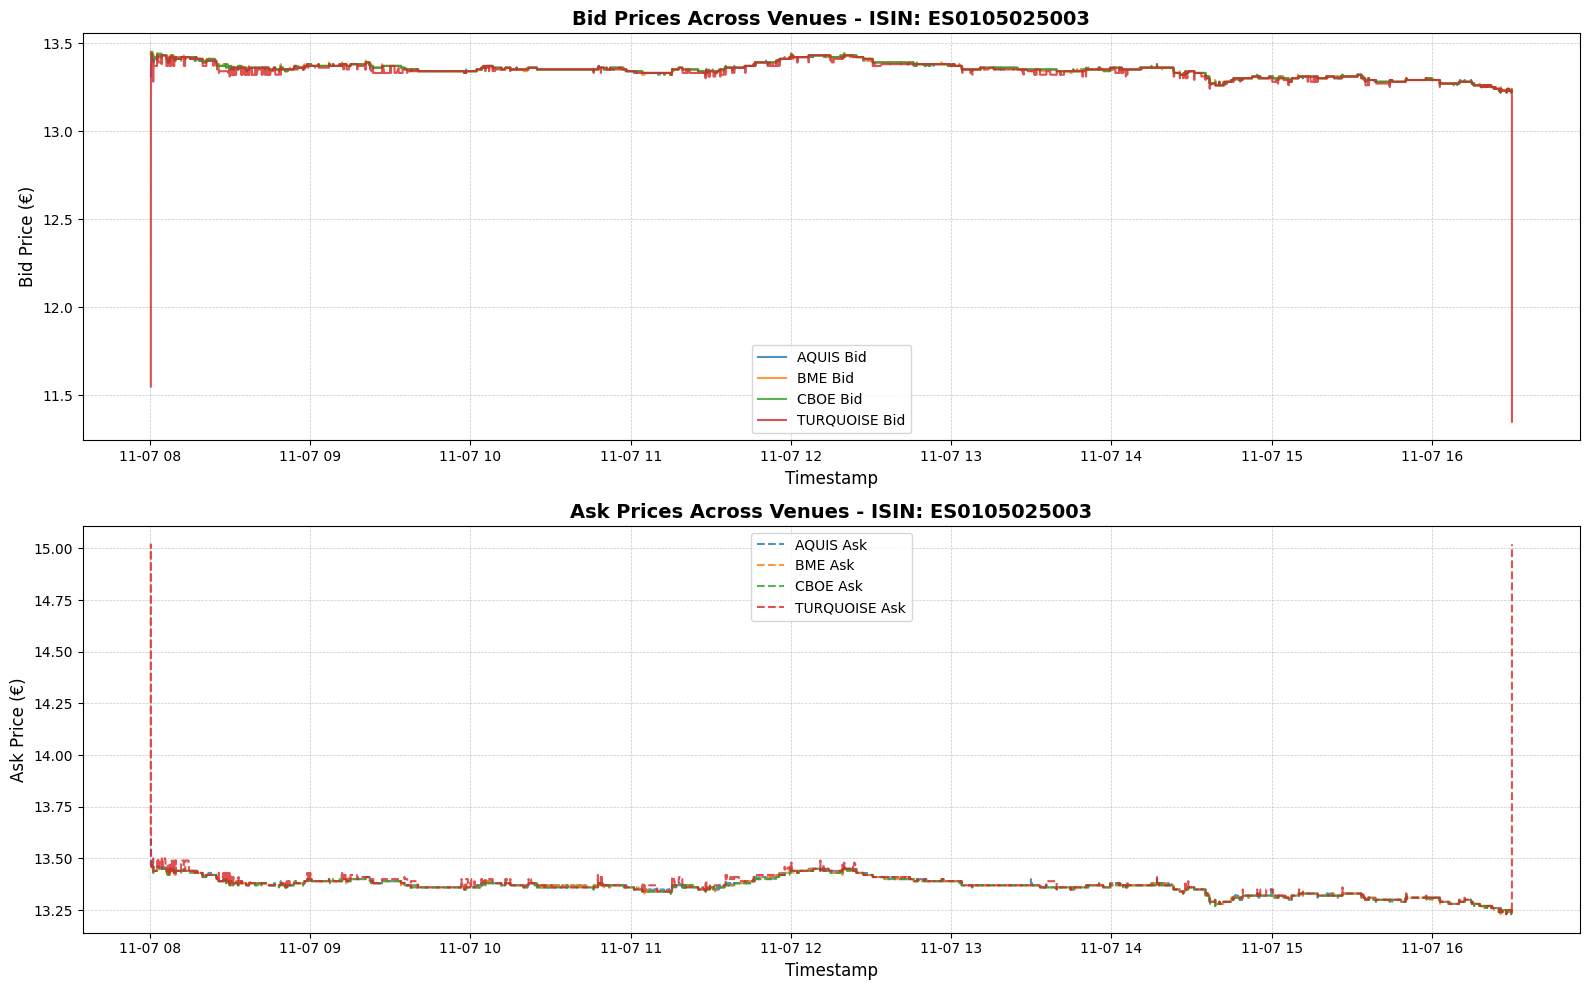


✓ Created price evolution plots for ES0105025003 (4 venues)


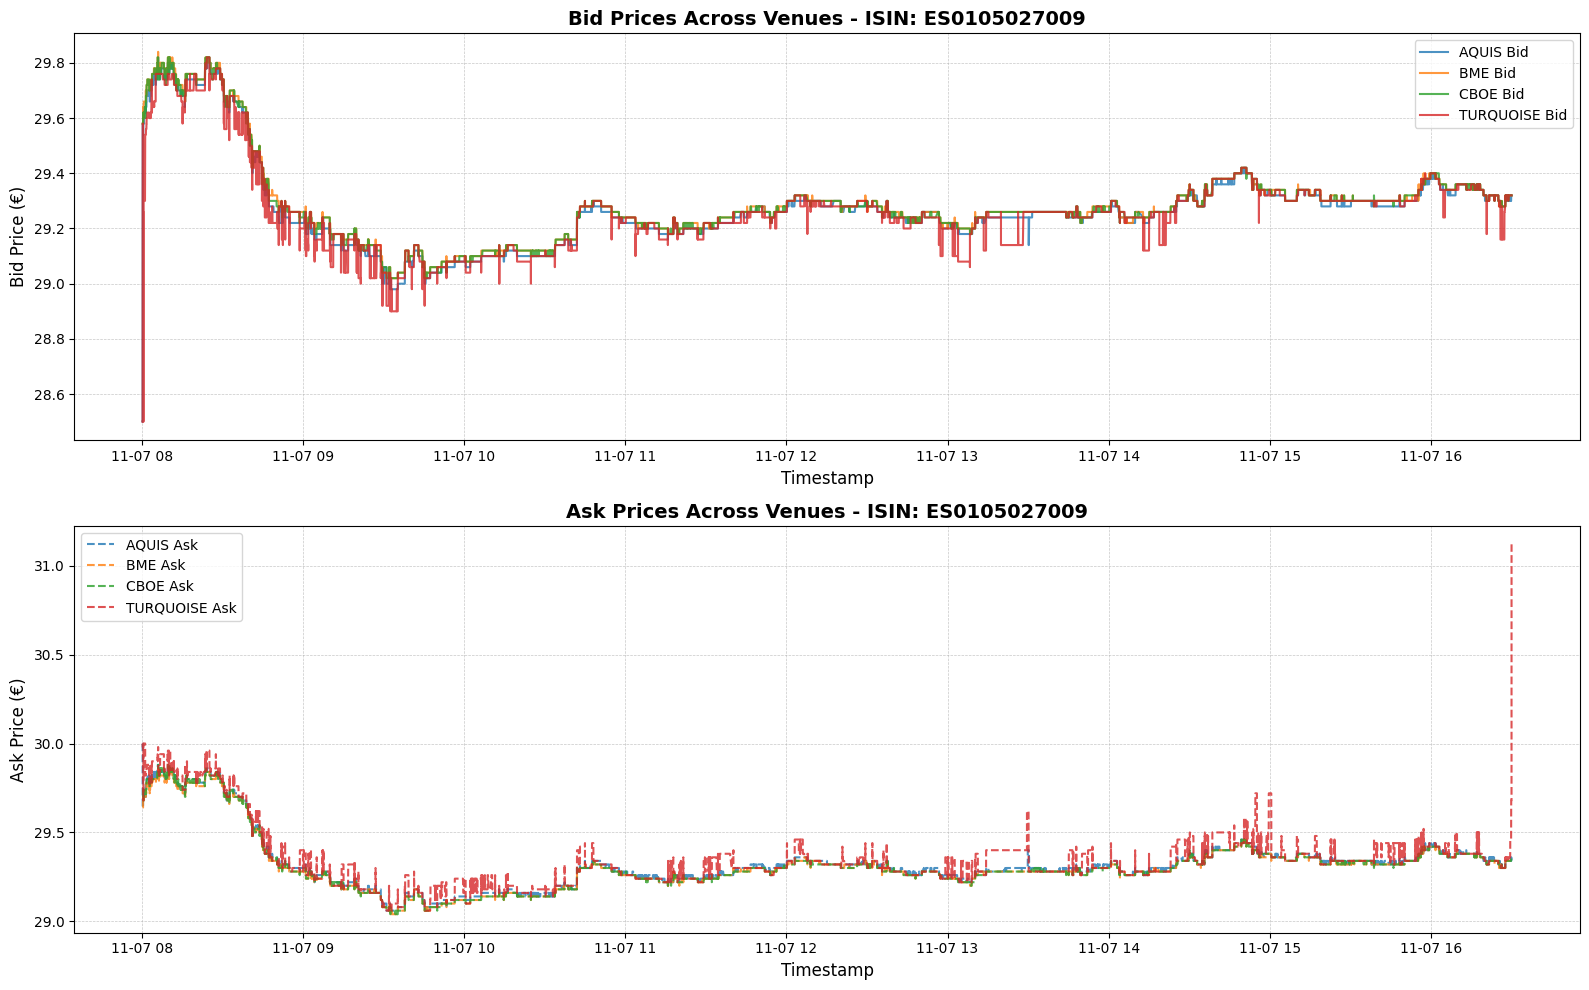


✓ Created price evolution plots for ES0105027009 (4 venues)



In [8]:
# ============================================================================
# VISUALIZATION 1: Price Evolution Across Venues (Multi-Venue Comparison)
# ============================================================================
# This visualization shows how prices evolve across different venues for
# selected ISINs, similar to the XMAD vs CEUX comparison in the reference notebook.
# ============================================================================

# Select representative ISINs with multiple venues (3-4 venues preferred)
# Priority: ISINs with good data coverage and multiple venues
selected_isins = []

# Find ISINs with 3-4 venues
for isin, tape in consolidated_tapes.items():
    bid_cols = [col for col in tape.columns if '_bid' in col]
    num_venues = len(bid_cols)
    if num_venues >= 3:
        selected_isins.append((isin, num_venues))
        if len(selected_isins) >= 3:  # Select top 3 ISINs
            break

# Sort by number of venues (descending)
selected_isins.sort(key=lambda x: x[1], reverse=True)

print("=" * 70)
print("VISUALIZATION 1: Price Evolution Across Venues")
print("=" * 70)
print(f"\nSelected ISINs for visualization: {[isin for isin, _ in selected_isins]}")

# Create visualizations for selected ISINs
for isin, num_venues in selected_isins[:2]:  # Show first 2 ISINs
    if isin not in consolidated_tapes:
        continue
    
    tape = consolidated_tapes[isin]
    
    # Get venue names
    bid_cols = [col for col in tape.columns if '_bid' in col]
    ask_cols = [col for col in tape.columns if '_ask' in col]
    venues = [col.replace('_bid', '') for col in bid_cols]
    
    # Use full trading day data (from market open to market close)
    if len(tape) > 0:
        # Use complete data range - from first to last timestamp
        time_window = tape
        
        if len(time_window) > 0:
            # Create figure
            fig, axes = plt.subplots(2, 1, figsize=(16, 10))
            
            # Plot 1: Bid Prices
            ax1 = axes[0]
            for venue in venues:
                bid_col = f'{venue}_bid'
                if bid_col in time_window.columns:
                    ax1.plot(time_window.index, time_window[bid_col], 
                            label=f'{venue} Bid', linewidth=1.5, alpha=0.8)
            
            ax1.set_title(f'Bid Prices Across Venues - ISIN: {isin}', fontsize=14, fontweight='bold')
            ax1.set_ylabel('Bid Price (€)', fontsize=12)
            ax1.set_xlabel('Timestamp', fontsize=12)
            ax1.legend(loc='best', fontsize=10)
            ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
            
            # Plot 2: Ask Prices
            ax2 = axes[1]
            for venue in venues:
                ask_col = f'{venue}_ask'
                if ask_col in time_window.columns:
                    ax2.plot(time_window.index, time_window[ask_col], 
                            label=f'{venue} Ask', linewidth=1.5, alpha=0.8, linestyle='--')
            
            ax2.set_title(f'Ask Prices Across Venues - ISIN: {isin}', fontsize=14, fontweight='bold')
            ax2.set_ylabel('Ask Price (€)', fontsize=12)
            ax2.set_xlabel('Timestamp', fontsize=12)
            ax2.legend(loc='best', fontsize=10)
            ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
            
            plt.tight_layout()
            plt.show()
            
            print(f"\n✓ Created price evolution plots for {isin} ({num_venues} venues)")

print("\n" + "=" * 70)


VISUALIZATION 2: Spread Analysis Between Venues


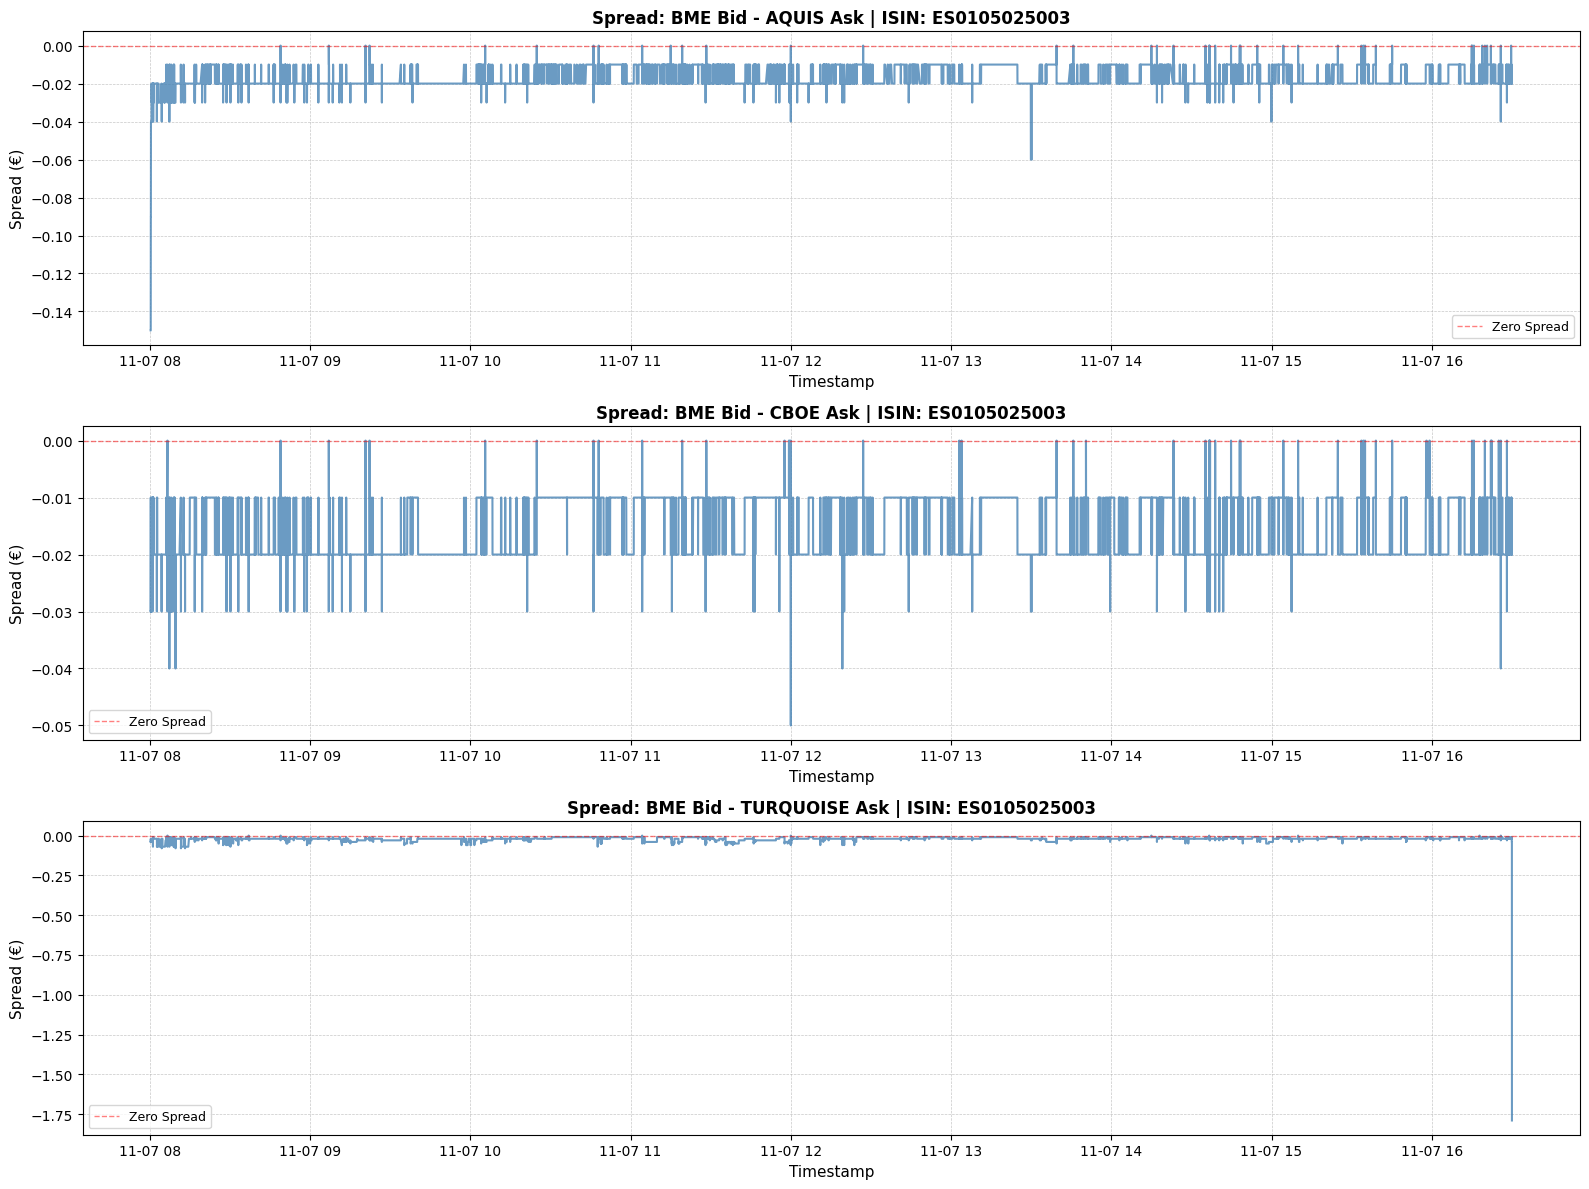

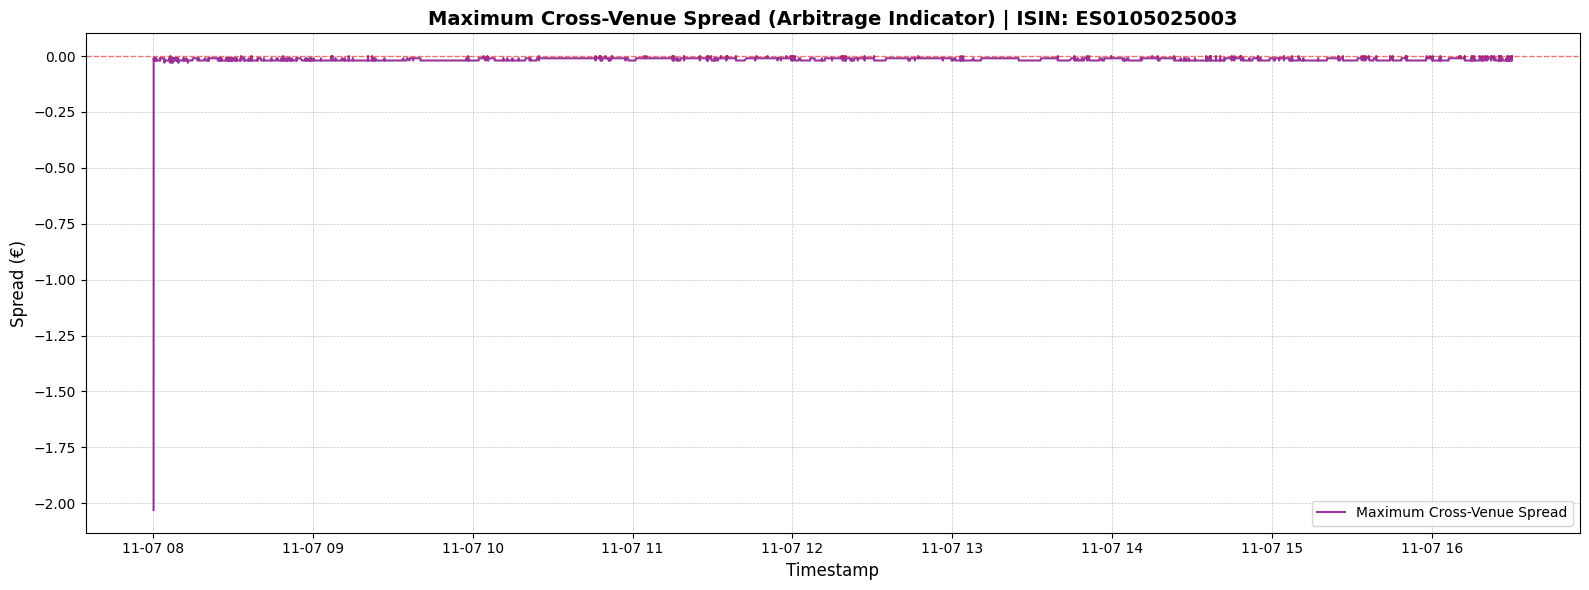


✓ Created spread analysis plots for ES0105025003


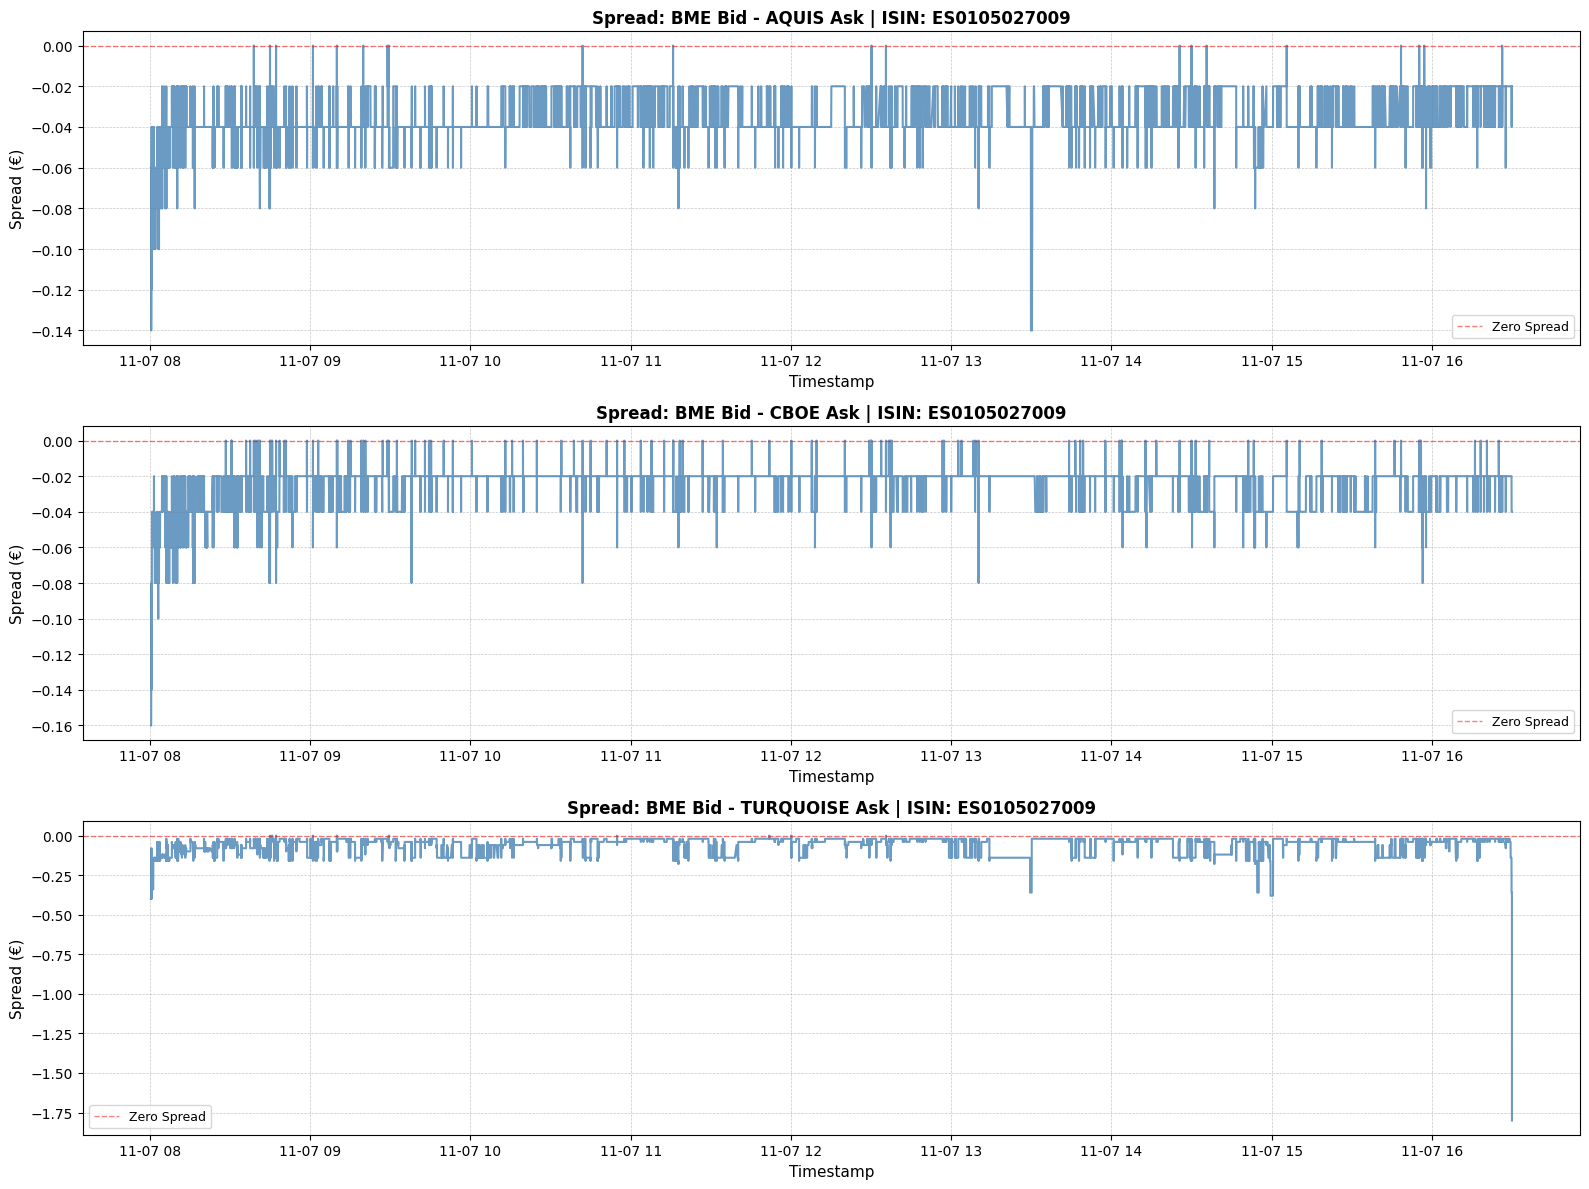

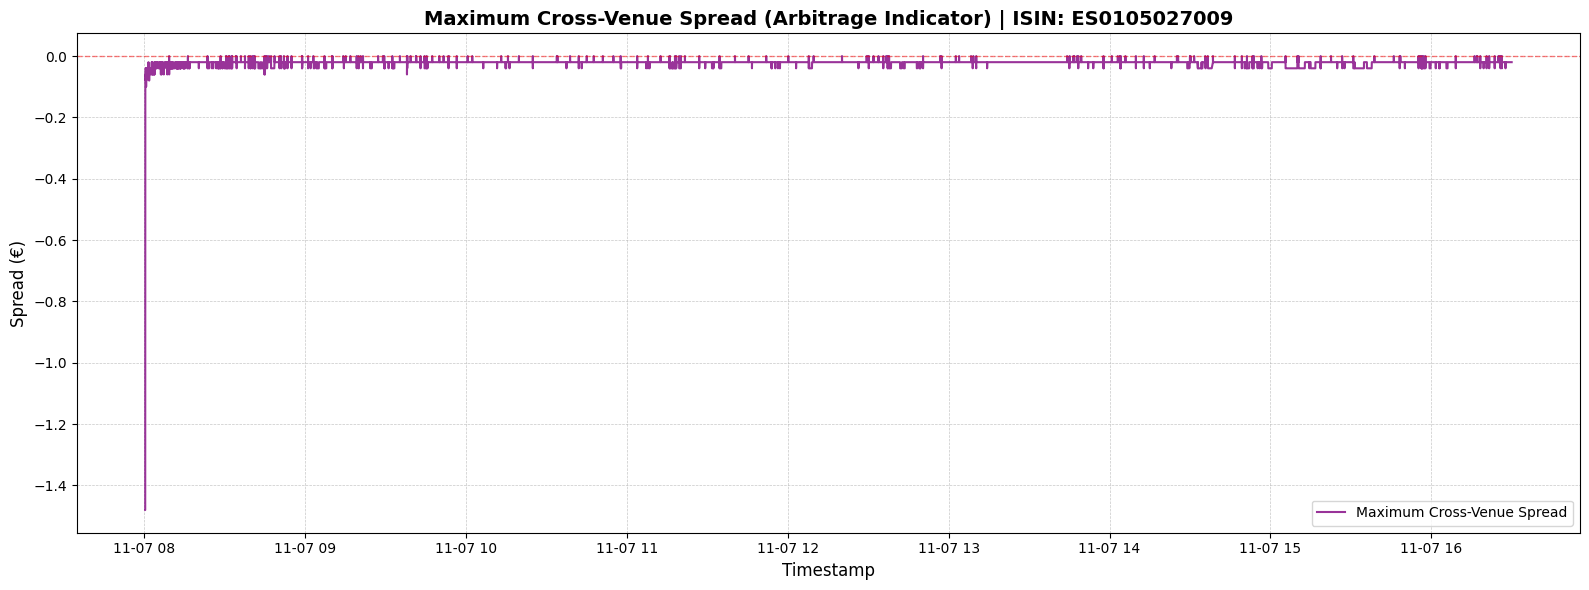


✓ Created spread analysis plots for ES0105027009



In [9]:
# ============================================================================
# VISUALIZATION 2: Spread Analysis (Price Differences Between Venues)
# ============================================================================
# This visualization shows price discrepancies between venues, similar to
# the spread plot in the reference notebook (XMAD - CEUX).
# ============================================================================

print("=" * 70)
print("VISUALIZATION 2: Spread Analysis Between Venues")
print("=" * 70)

# Use the same selected ISINs from Visualization 1
for isin, num_venues in selected_isins[:2]:  # Show first 2 ISINs
    if isin not in consolidated_tapes:
        continue
    
    tape = consolidated_tapes[isin]
    
    # Get venue names
    bid_cols = [col for col in tape.columns if '_bid' in col]
    venues = [col.replace('_bid', '') for col in bid_cols]
    
    if len(venues) < 2:
        continue
    
    # Use full trading day data (from market open to market close)
    time_window = tape
    
    if len(time_window) == 0:
        continue
    
    # Calculate spreads between venue pairs
    # Use BME as reference if available, otherwise use first venue
    reference_venue = 'BME' if 'BME' in venues else venues[0]
    
    # Create figure with subplots
    num_pairs = min(3, len(venues) - 1)  # Show up to 3 spread pairs
    fig, axes = plt.subplots(num_pairs, 1, figsize=(16, 4 * num_pairs))
    
    if num_pairs == 1:
        axes = [axes]
    
    plot_idx = 0
    for other_venue in venues:
        if other_venue == reference_venue or plot_idx >= num_pairs:
            continue
        
        # Calculate spread: Reference Bid - Other Ask (potential arbitrage direction)
        ref_bid_col = f'{reference_venue}_bid'
        other_ask_col = f'{other_venue}_ask'
        
        if ref_bid_col in time_window.columns and other_ask_col in time_window.columns:
            spread = time_window[ref_bid_col] - time_window[other_ask_col]
            
            ax = axes[plot_idx]
            ax.plot(time_window.index, spread, linewidth=1.5, alpha=0.8, color='steelblue')
            ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Zero Spread')
            
            # Highlight positive spreads (potential arbitrage)
            positive_spread = spread[spread > 0]
            if len(positive_spread) > 0:
                ax.scatter(positive_spread.index, positive_spread.values, 
                          color='green', s=10, alpha=0.6, label='Positive Spread (Arbitrage Opportunity)')
            
            ax.set_title(f'Spread: {reference_venue} Bid - {other_venue} Ask | ISIN: {isin}', 
                        fontsize=12, fontweight='bold')
            ax.set_ylabel('Spread (€)', fontsize=11)
            ax.set_xlabel('Timestamp', fontsize=11)
            ax.legend(loc='best', fontsize=9)
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
            
            plot_idx += 1
    
    plt.tight_layout()
    plt.show()
    
    # Also create a combined spread visualization
    if len(venues) >= 2:
        fig, ax = plt.subplots(figsize=(16, 6))
        
        # Calculate all pairwise spreads and plot the maximum spread
        max_spreads = []
        min_spreads = []
        
        for i, venue1 in enumerate(venues):
            for venue2 in venues[i+1:]:
                bid_col1 = f'{venue1}_bid'
                ask_col2 = f'{venue2}_ask'
                bid_col2 = f'{venue2}_bid'
                ask_col1 = f'{venue1}_ask'
                
                if all(col in time_window.columns for col in [bid_col1, ask_col2, bid_col2, ask_col1]):
                    # Spread in both directions
                    spread1 = time_window[bid_col1] - time_window[ask_col2]
                    spread2 = time_window[bid_col2] - time_window[ask_col1]
                    
                    # Take the maximum spread at each timestamp
                    combined_spread = pd.concat([spread1, spread2], axis=1).max(axis=1)
                    max_spreads.append(combined_spread)
        
        if max_spreads:
            overall_max_spread = pd.concat(max_spreads, axis=1).max(axis=1)
            ax.plot(time_window.index, overall_max_spread, linewidth=1.5, alpha=0.8, 
                   color='purple', label='Maximum Cross-Venue Spread')
            ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
            
            # Highlight positive regions
            positive_regions = overall_max_spread[overall_max_spread > 0]
            if len(positive_regions) > 0:
                ax.fill_between(positive_regions.index, 0, positive_regions.values, 
                              alpha=0.3, color='green', label='Arbitrage Opportunity Regions')
            
            ax.set_title(f'Maximum Cross-Venue Spread (Arbitrage Indicator) | ISIN: {isin}', 
                        fontsize=14, fontweight='bold')
            ax.set_ylabel('Spread (€)', fontsize=12)
            ax.set_xlabel('Timestamp', fontsize=12)
            ax.legend(loc='best', fontsize=10)
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
            
            plt.tight_layout()
            plt.show()
    
    print(f"\n✓ Created spread analysis plots for {isin}")

print("\n" + "=" * 70)


VISUALIZATION 3: Bid-Ask Spread Per Venue


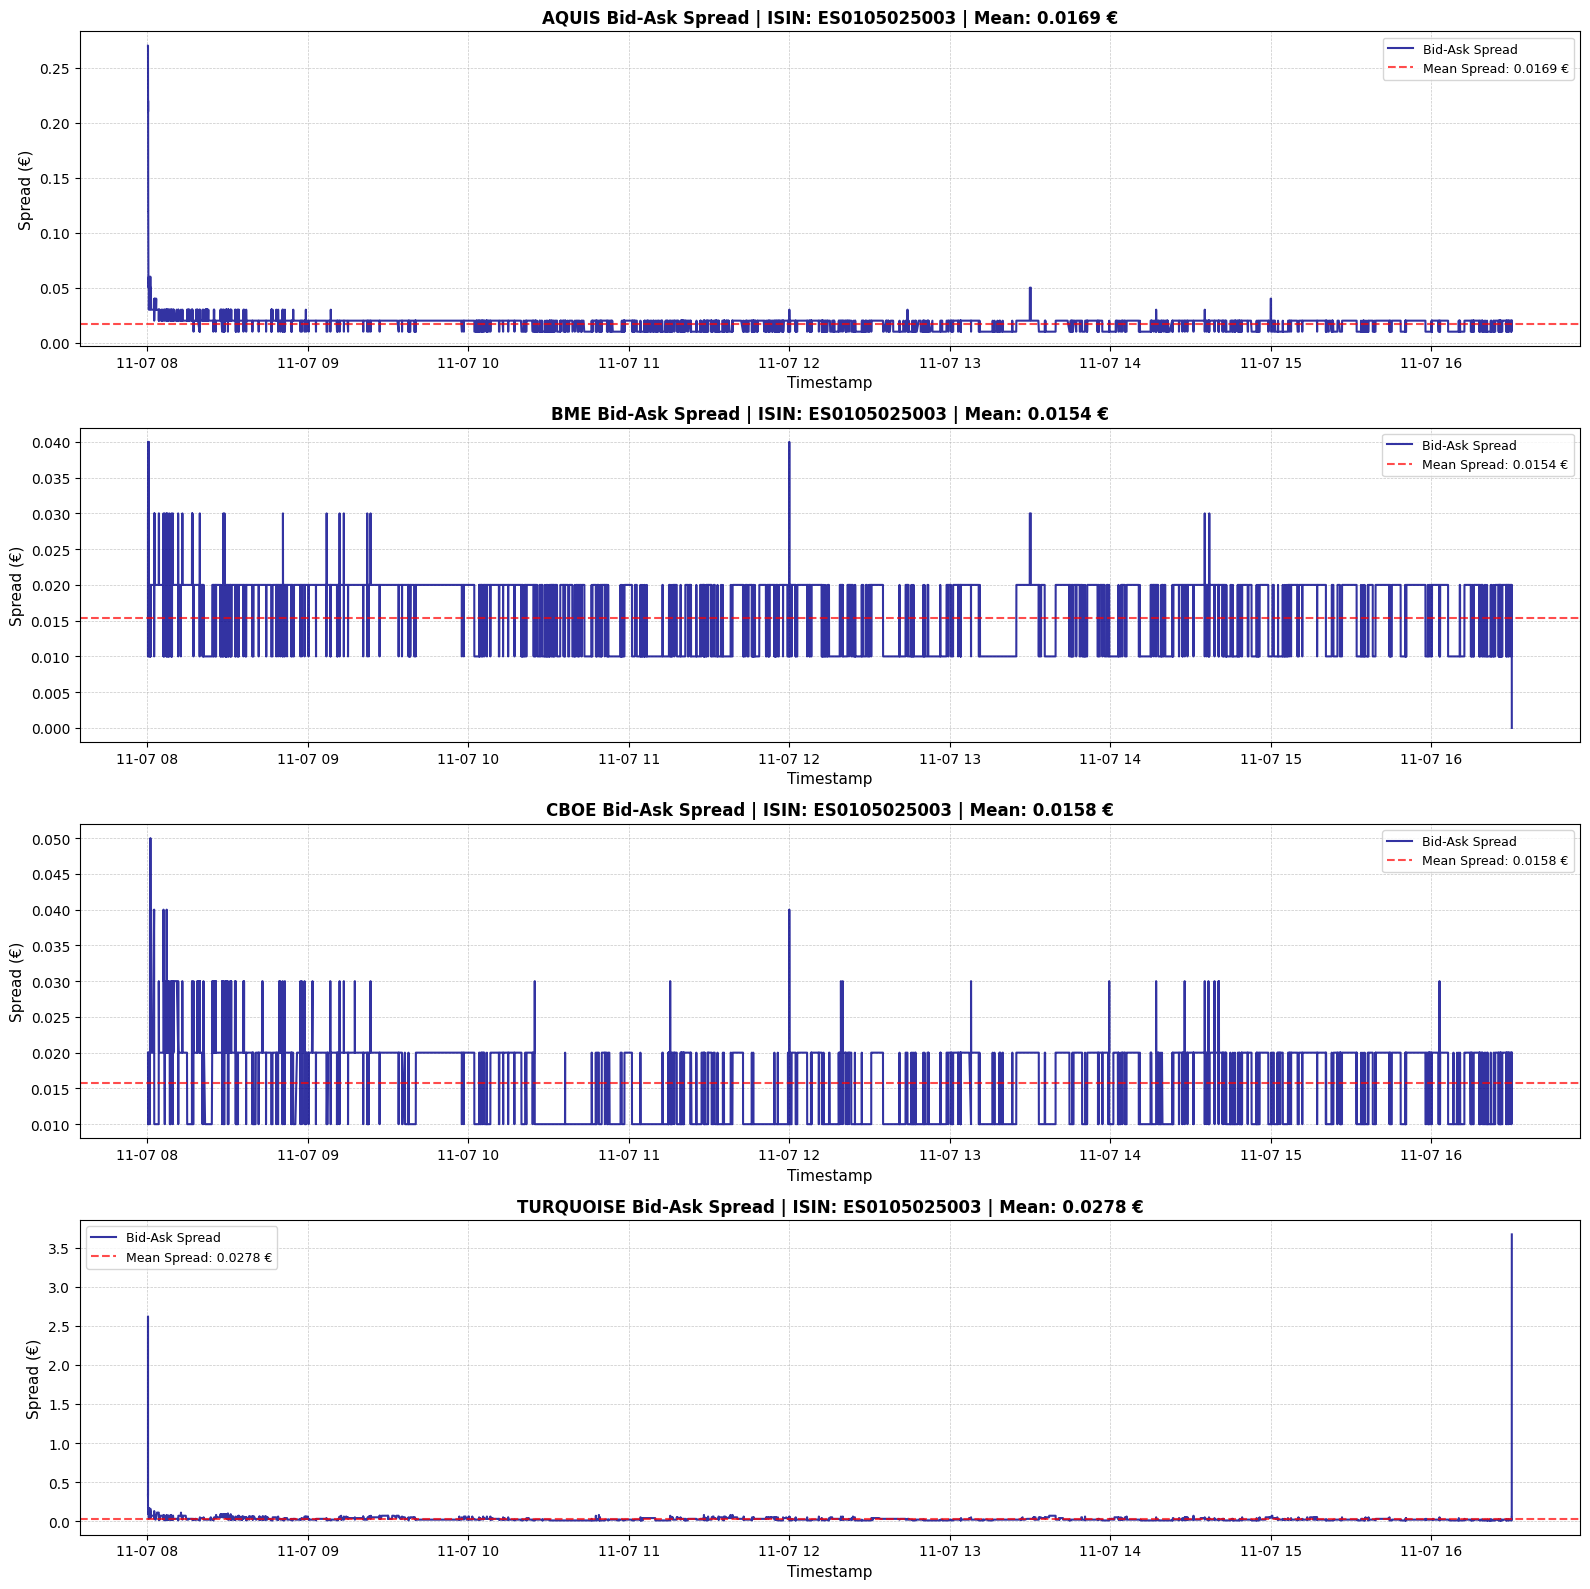

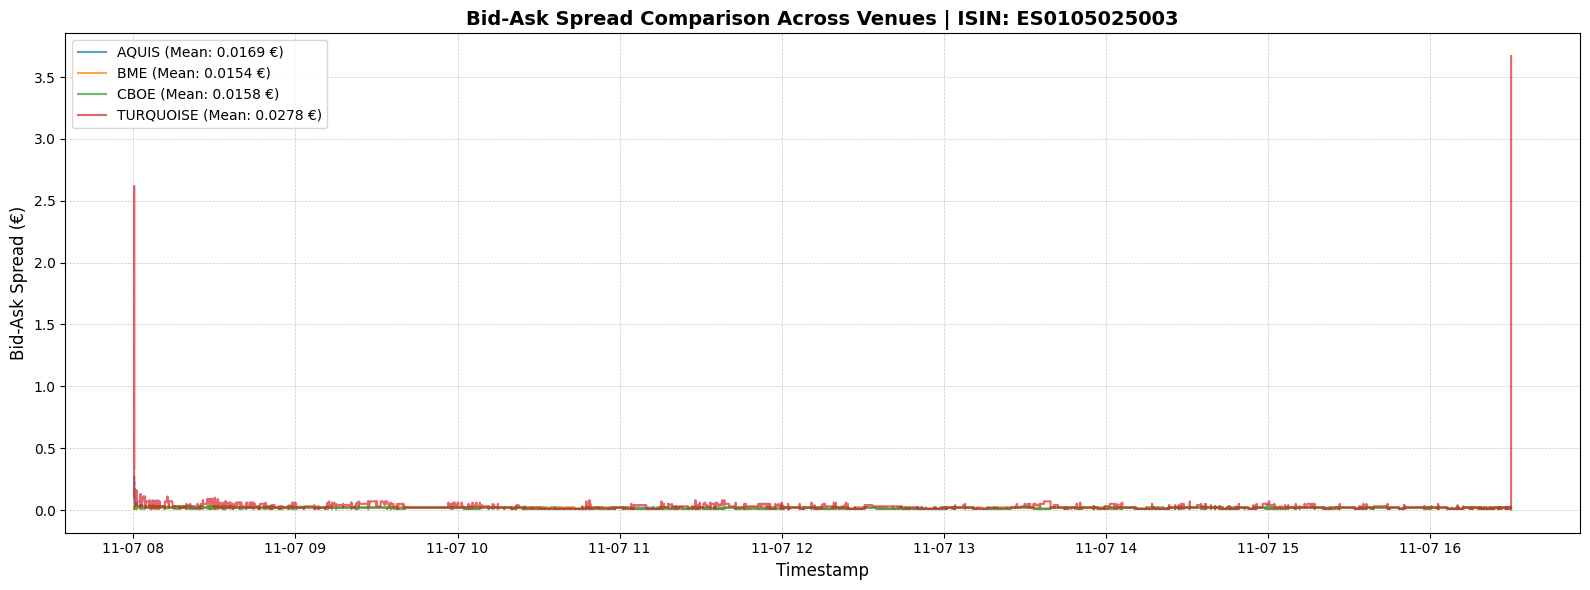


✓ Created bid-ask spread plots for ES0105025003


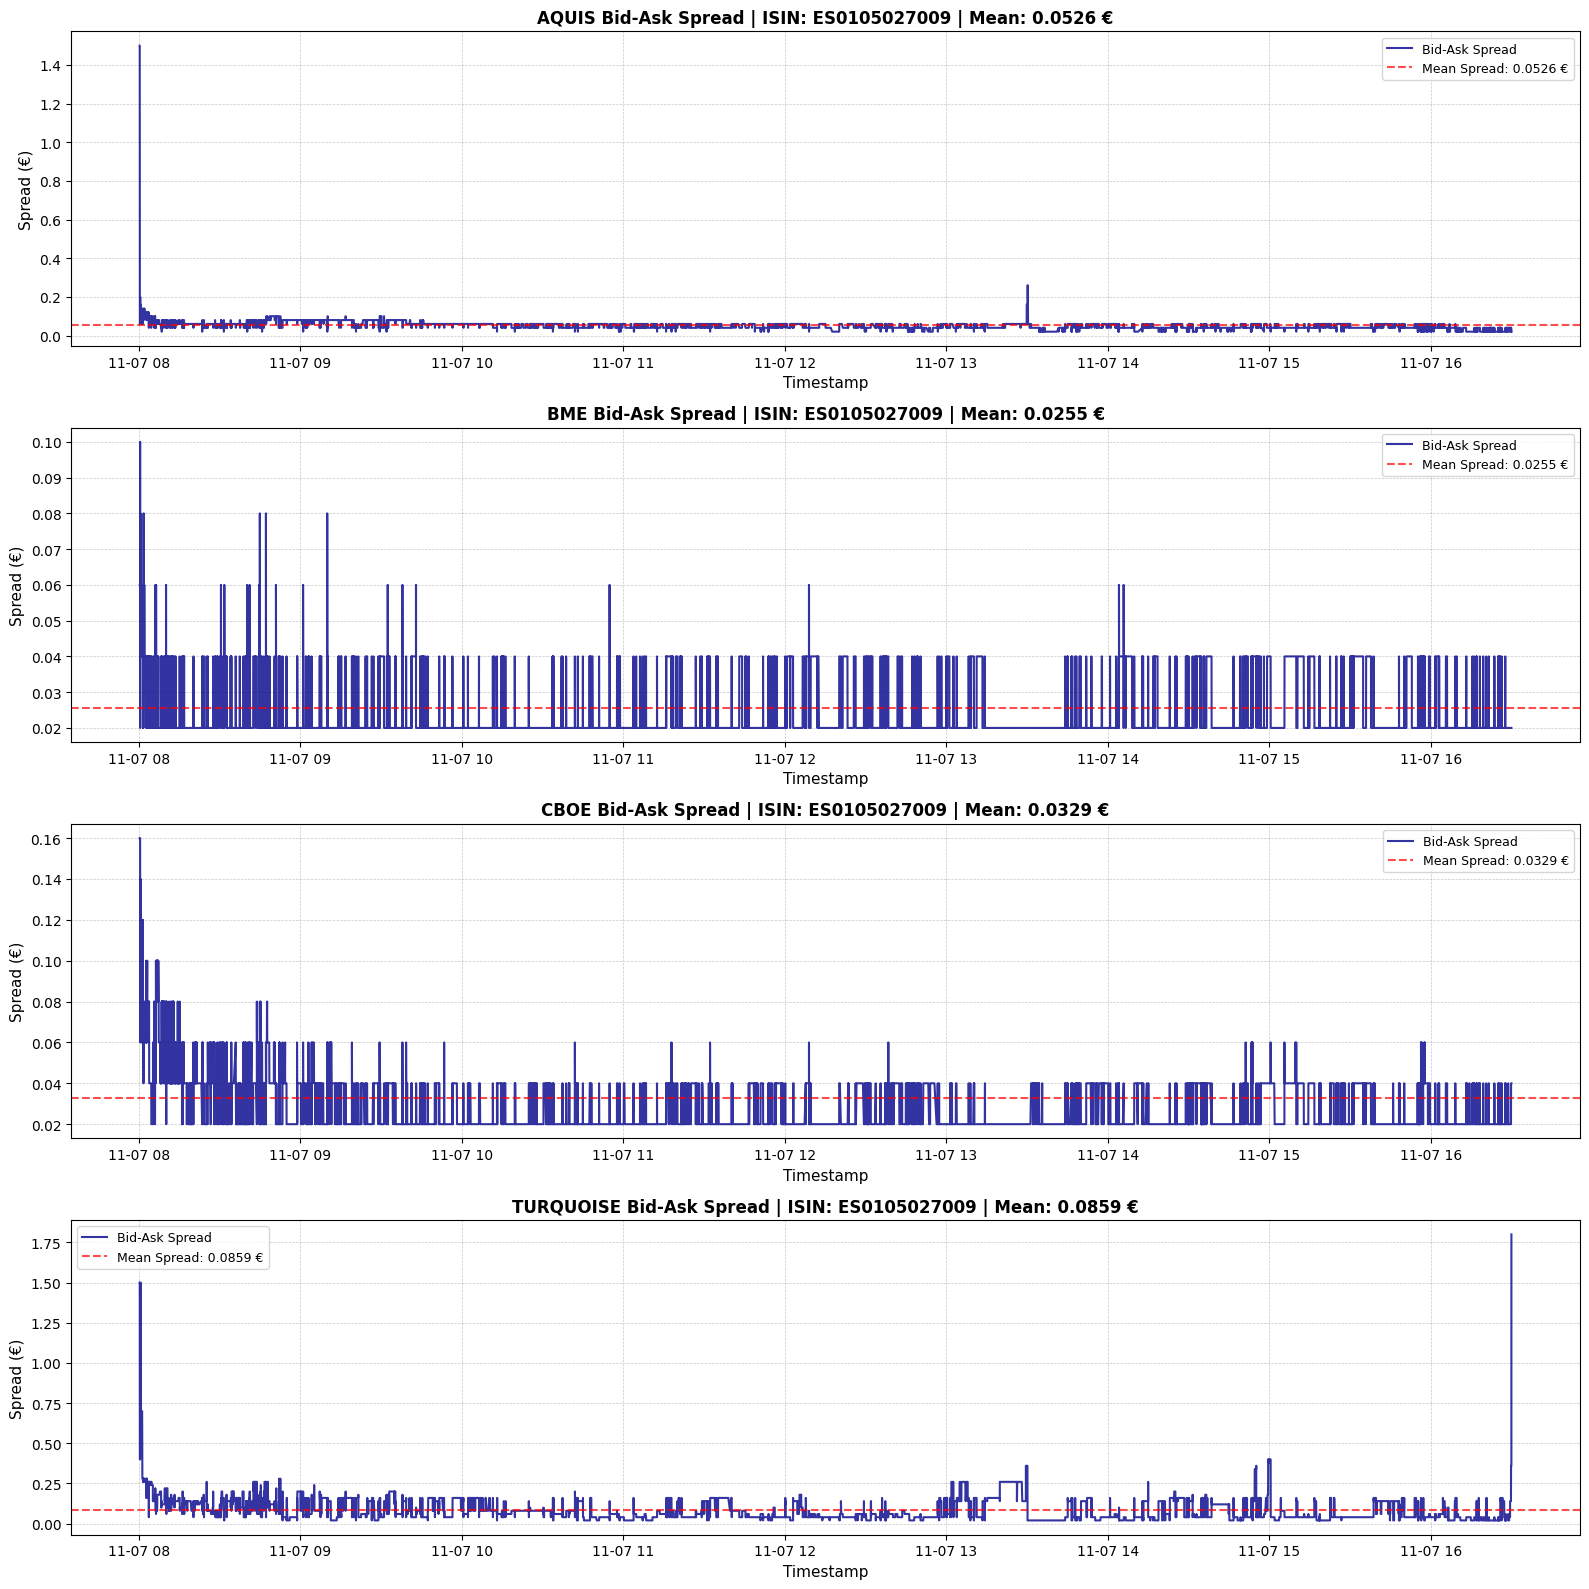

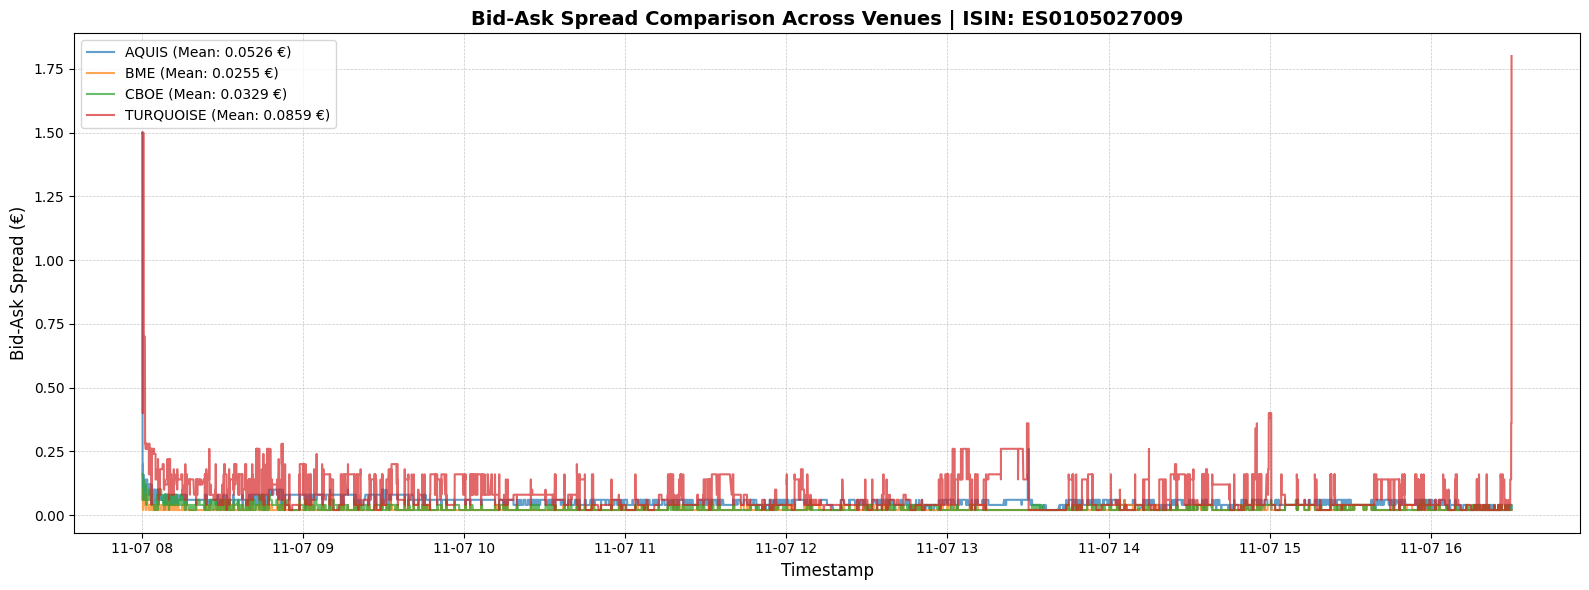


✓ Created bid-ask spread plots for ES0105027009



In [10]:
# ============================================================================
# VISUALIZATION 3: Bid-Ask Spread Per Venue
# ============================================================================
# This visualization shows the bid-ask spread (liquidity cost) for each venue.
# Tighter spreads indicate better liquidity.
# ============================================================================

print("=" * 70)
print("VISUALIZATION 3: Bid-Ask Spread Per Venue")
print("=" * 70)

for isin, num_venues in selected_isins[:2]:  # Show first 2 ISINs
    if isin not in consolidated_tapes:
        continue
    
    tape = consolidated_tapes[isin]
    
    # Get venue names
    bid_cols = [col for col in tape.columns if '_bid' in col]
    venues = [col.replace('_bid', '') for col in bid_cols]
    
    # Use full trading day data (from market open to market close)
    time_window = tape
    
    if len(time_window) == 0:
        continue
    
    # Calculate bid-ask spread for each venue
    fig, axes = plt.subplots(len(venues), 1, figsize=(16, 4 * len(venues)))
    
    if len(venues) == 1:
        axes = [axes]
    
    for idx, venue in enumerate(venues):
        bid_col = f'{venue}_bid'
        ask_col = f'{venue}_ask'
        
        if bid_col in time_window.columns and ask_col in time_window.columns:
            # Calculate spread: Ask - Bid
            spread = time_window[ask_col] - time_window[bid_col]
            
            # Remove NaN values
            spread_clean = spread.dropna()
            
            if len(spread_clean) > 0:
                ax = axes[idx]
                ax.plot(spread_clean.index, spread_clean.values, 
                       linewidth=1.5, alpha=0.8, color='darkblue', label='Bid-Ask Spread')
                
                # Add mean line
                mean_spread = spread_clean.mean()
                ax.axhline(y=mean_spread, color='red', linestyle='--', 
                          linewidth=1.5, alpha=0.7, label=f'Mean Spread: {mean_spread:.4f} €')
                
                ax.set_title(f'{venue} Bid-Ask Spread | ISIN: {isin} | Mean: {mean_spread:.4f} €', 
                            fontsize=12, fontweight='bold')
                ax.set_ylabel('Spread (€)', fontsize=11)
                ax.set_xlabel('Timestamp', fontsize=11)
                ax.legend(loc='best', fontsize=9)
                ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Create a comparison plot showing all venues together
    fig, ax = plt.subplots(figsize=(16, 6))
    
    for venue in venues:
        bid_col = f'{venue}_bid'
        ask_col = f'{venue}_ask'
        
        if bid_col in time_window.columns and ask_col in time_window.columns:
            spread = time_window[ask_col] - time_window[bid_col]
            spread_clean = spread.dropna()
            
            if len(spread_clean) > 0:
                ax.plot(spread_clean.index, spread_clean.values, 
                       linewidth=1.5, alpha=0.7, label=f'{venue} (Mean: {spread_clean.mean():.4f} €)')
    
    ax.set_title(f'Bid-Ask Spread Comparison Across Venues | ISIN: {isin}', 
                fontsize=14, fontweight='bold')
    ax.set_ylabel('Bid-Ask Spread (€)', fontsize=12)
    ax.set_xlabel('Timestamp', fontsize=12)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Created bid-ask spread plots for {isin}")

print("\n" + "=" * 70)


VISUALIZATION 4: Arbitrage Opportunity Detection

Found 65 ISINs with arbitrage opportunities
Top ISINs with arbitrage opportunities:
  ES0177542018: 27,150 opportunities, max profit: 0.0190 €
  FR0011036268: 24,642 opportunities, max profit: 0.0108 €
  FR0010251744: 4,660 opportunities, max profit: 0.9000 €
  ES0113900J37: 4,062 opportunities, max profit: 0.0150 €
  ES0105079000: 2,164 opportunities, max profit: 0.6000 €


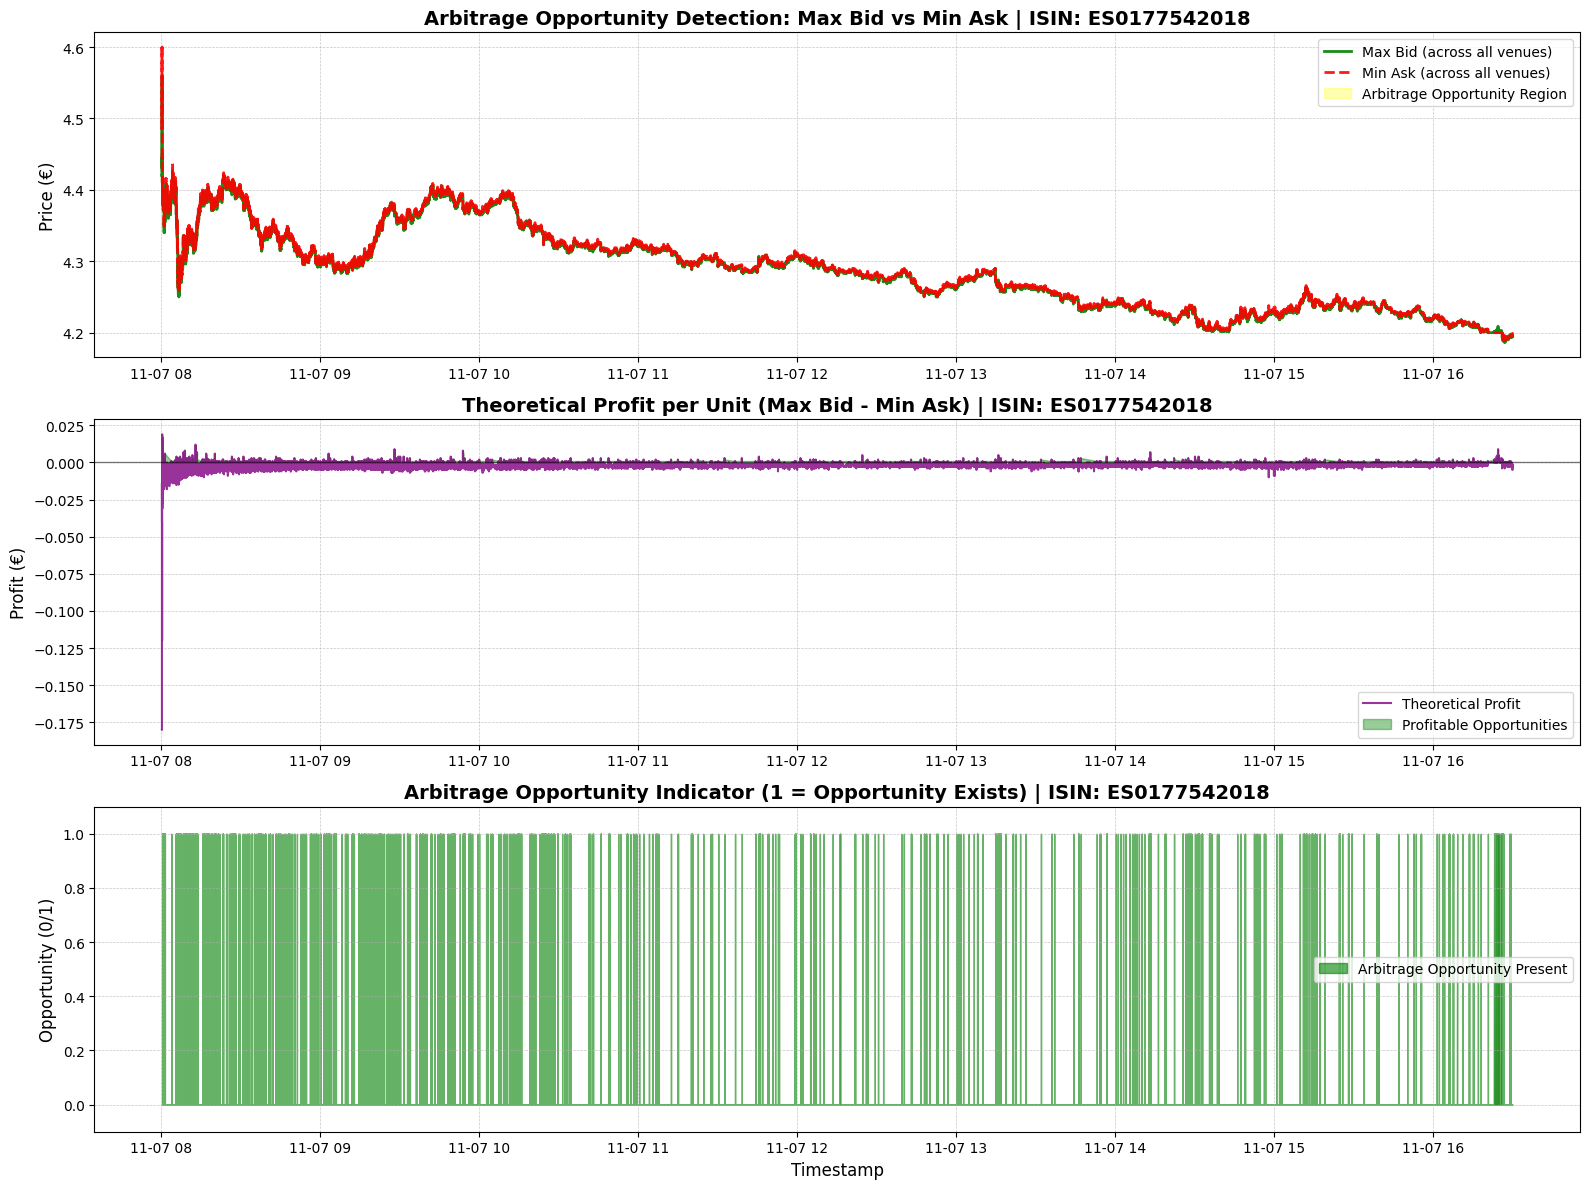


📊 Arbitrage Statistics for ES0177542018:
   • Total timestamps analyzed: 1,112,501
   • Arbitrage opportunities found: 27,150 (2.44%)
   • Maximum theoretical profit: 0.0190 €
   • Mean profit (when opportunity exists): 0.0017 €

✓ Created arbitrage opportunity plots for ES0177542018


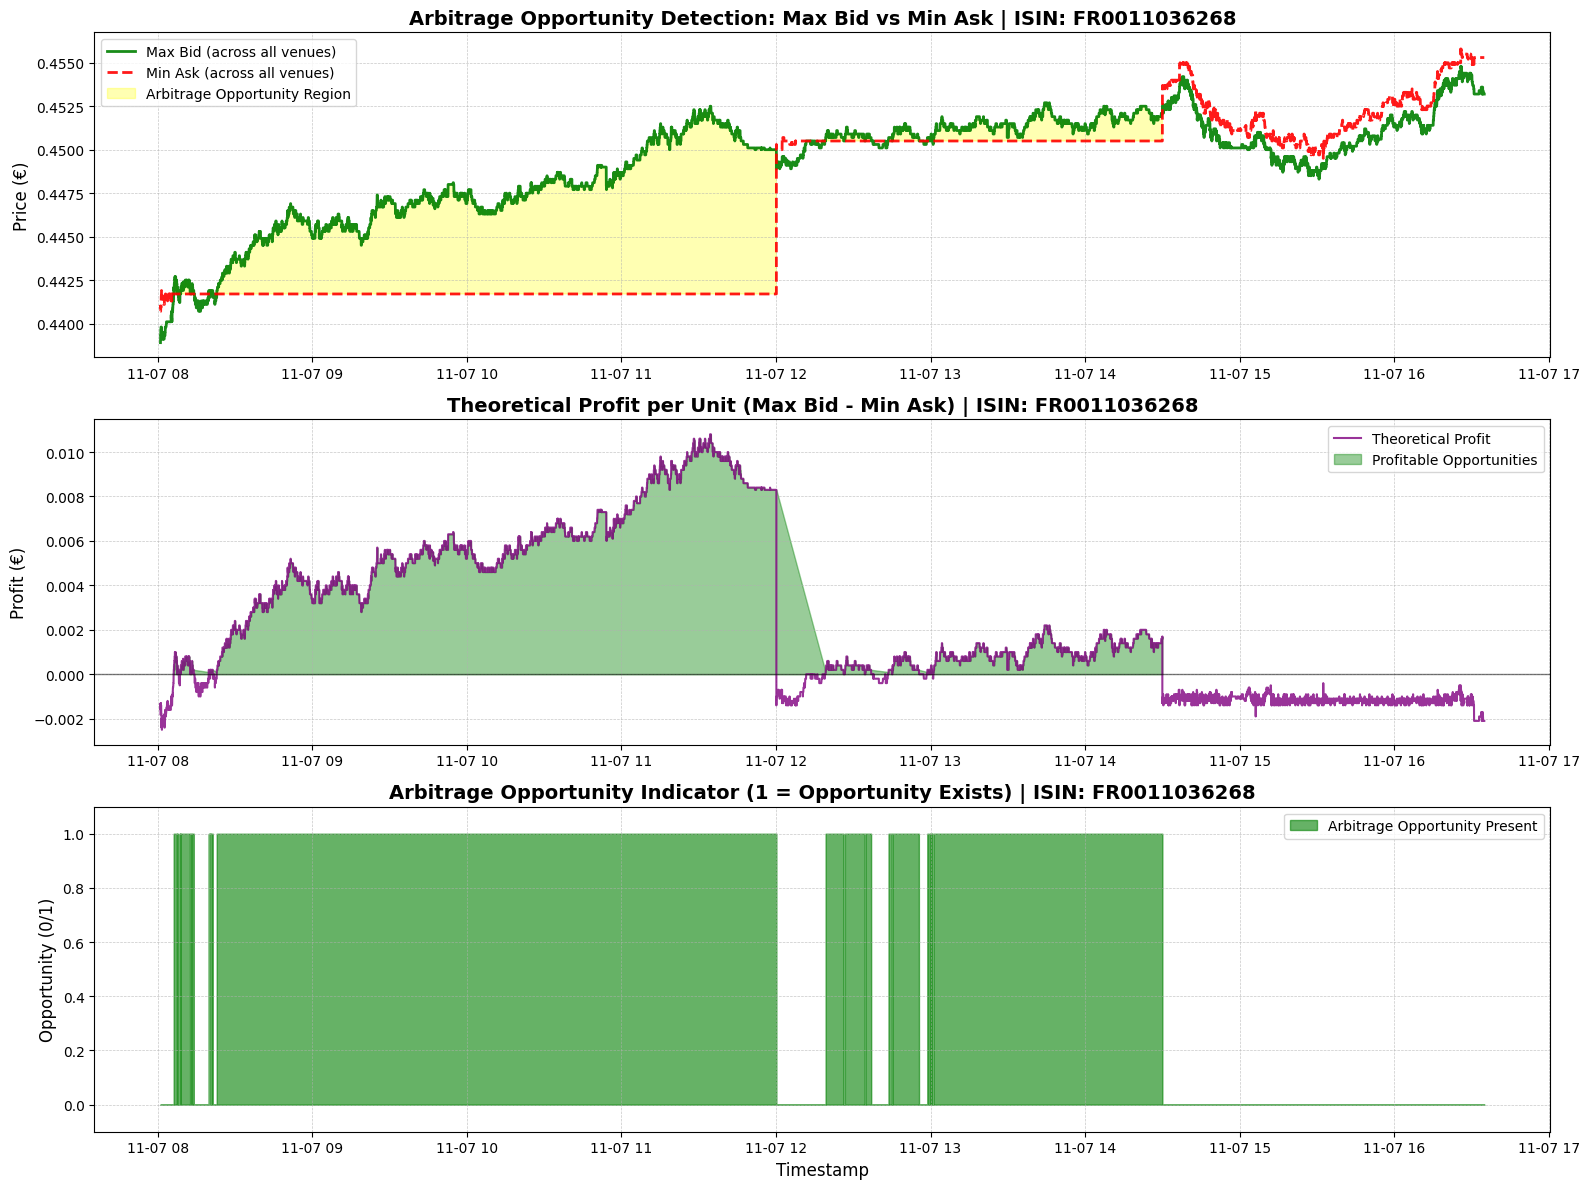


📊 Arbitrage Statistics for FR0011036268:
   • Total timestamps analyzed: 40,510
   • Arbitrage opportunities found: 24,642 (60.83%)
   • Maximum theoretical profit: 0.0108 €
   • Mean profit (when opportunity exists): 0.0044 €

✓ Created arbitrage opportunity plots for FR0011036268



In [11]:
# ============================================================================
# VISUALIZATION 4: Arbitrage Opportunity Visualization
# ============================================================================
# This visualization identifies where arbitrage opportunities exist by showing
# max_bid (across all venues) vs min_ask (across all venues).
# When max_bid > min_ask, an arbitrage opportunity exists.
# ============================================================================

print("=" * 70)
print("VISUALIZATION 4: Arbitrage Opportunity Detection")
print("=" * 70)

# Find ISINs that actually have arbitrage opportunities
arbitrage_isins = []

for isin, tape in consolidated_tapes.items():
    bid_cols = [col for col in tape.columns if '_bid' in col]
    ask_cols = [col for col in tape.columns if '_ask' in col]
    
    if len(bid_cols) < 2:  # Need at least 2 venues for arbitrage
        continue
    
    # Calculate max bid and min ask across all venues
    max_bid = tape[bid_cols].max(axis=1)
    min_ask = tape[ask_cols].min(axis=1)
    
    # Check if there are any arbitrage opportunities
    theoretical_profit = max_bid - min_ask
    arbitrage_opportunity = theoretical_profit > 0
    
    if arbitrage_opportunity.sum() > 0:  # Has at least some arbitrage opportunities
        num_opportunities = arbitrage_opportunity.sum()
        max_profit = theoretical_profit.max()
        arbitrage_isins.append((isin, len(bid_cols), num_opportunities, max_profit))

# Sort by number of opportunities (descending), then by max profit
arbitrage_isins.sort(key=lambda x: (x[2], x[3]), reverse=True)

print(f"\nFound {len(arbitrage_isins)} ISINs with arbitrage opportunities")
if len(arbitrage_isins) > 0:
    print(f"Top ISINs with arbitrage opportunities:")
    for isin, num_venues, num_opps, max_prof in arbitrage_isins[:5]:
        print(f"  {isin}: {num_opps:,} opportunities, max profit: {max_prof:.4f} €")

# Use ISINs with arbitrage opportunities, or fall back to selected_isins if none found
if len(arbitrage_isins) > 0:
    display_isins = arbitrage_isins[:2]  # Show top 2 ISINs with arbitrage
else:
    print("\n⚠️  No ISINs with arbitrage opportunities found. Using selected ISINs instead.")
    display_isins = [(isin, num_venues, 0, 0) for isin, num_venues in selected_isins[:2]]

for isin_info in display_isins:
    isin = isin_info[0]
    num_venues = isin_info[1]
    
    if isin not in consolidated_tapes:
        continue
    
    tape = consolidated_tapes[isin]
    
    # Get all bid and ask columns
    bid_cols = [col for col in tape.columns if '_bid' in col]
    ask_cols = [col for col in tape.columns if '_ask' in col]
    
    if len(bid_cols) < 2:  # Need at least 2 venues for arbitrage
        continue
    
    # Use full trading day data (from market open to market close)
    time_window = tape
    
    if len(time_window) == 0:
        continue
    
    # Calculate max bid and min ask across all venues at each timestamp
    max_bid = time_window[bid_cols].max(axis=1)
    min_ask = time_window[ask_cols].min(axis=1)
    
    # Calculate theoretical profit (arbitrage opportunity)
    # Profit exists when max_bid > min_ask
    theoretical_profit = max_bid - min_ask
    arbitrage_opportunity = theoretical_profit > 0
    
    # Create main visualization
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    
    # Plot 1: Max Bid vs Min Ask
    ax1 = axes[0]
    ax1.plot(time_window.index, max_bid, label='Max Bid (across all venues)', 
            linewidth=2, alpha=0.9, color='green')
    ax1.plot(time_window.index, min_ask, label='Min Ask (across all venues)', 
            linewidth=2, alpha=0.9, color='red', linestyle='--')
    
    # Highlight arbitrage opportunities (where max_bid > min_ask)
    arb_mask = arbitrage_opportunity
    if arb_mask.sum() > 0:
        ax1.fill_between(time_window.index, max_bid, min_ask, 
                         where=arb_mask, alpha=0.3, color='yellow', 
                         label='Arbitrage Opportunity Region')
    
    ax1.set_title(f'Arbitrage Opportunity Detection: Max Bid vs Min Ask | ISIN: {isin}', 
                 fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price (€)', fontsize=12)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Plot 2: Theoretical Profit
    ax2 = axes[1]
    ax2.plot(time_window.index, theoretical_profit, 
            linewidth=1.5, alpha=0.8, color='purple', label='Theoretical Profit')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    # Highlight positive profit regions
    positive_profit = theoretical_profit[theoretical_profit > 0]
    if len(positive_profit) > 0:
        ax2.fill_between(positive_profit.index, 0, positive_profit.values, 
                        alpha=0.4, color='green', label='Profitable Opportunities')
    
    ax2.set_title(f'Theoretical Profit per Unit (Max Bid - Min Ask) | ISIN: {isin}', 
                 fontsize=14, fontweight='bold')
    ax2.set_ylabel('Profit (€)', fontsize=12)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Plot 3: Arbitrage Opportunity Indicator (Binary)
    ax3 = axes[2]
    ax3.fill_between(time_window.index, 0, arbitrage_opportunity.astype(int), 
                    alpha=0.6, color='green', label='Arbitrage Opportunity Present')
    ax3.set_title(f'Arbitrage Opportunity Indicator (1 = Opportunity Exists) | ISIN: {isin}', 
                 fontsize=14, fontweight='bold')
    ax3.set_ylabel('Opportunity (0/1)', fontsize=12)
    ax3.set_xlabel('Timestamp', fontsize=12)
    ax3.set_ylim(-0.1, 1.1)
    ax3.legend(loc='best', fontsize=10)
    ax3.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    num_opportunities = arbitrage_opportunity.sum()
    total_timestamps = len(arbitrage_opportunity)
    opportunity_pct = (num_opportunities / total_timestamps) * 100 if total_timestamps > 0 else 0
    
    if num_opportunities > 0:
        max_profit = theoretical_profit.max()
        mean_profit = positive_profit.mean() if len(positive_profit) > 0 else 0
        
        print(f"\n📊 Arbitrage Statistics for {isin}:")
        print(f"   • Total timestamps analyzed: {total_timestamps:,}")
        print(f"   • Arbitrage opportunities found: {num_opportunities:,} ({opportunity_pct:.2f}%)")
        print(f"   • Maximum theoretical profit: {max_profit:.4f} €")
        print(f"   • Mean profit (when opportunity exists): {mean_profit:.4f} €")
    else:
        print(f"\n⚠️  No arbitrage opportunities found for {isin} in the selected time window")
    
    print(f"\n✓ Created arbitrage opportunity plots for {isin}")

print("\n" + "=" * 70)


VISUALIZATION 5: Summary Statistics Visualization


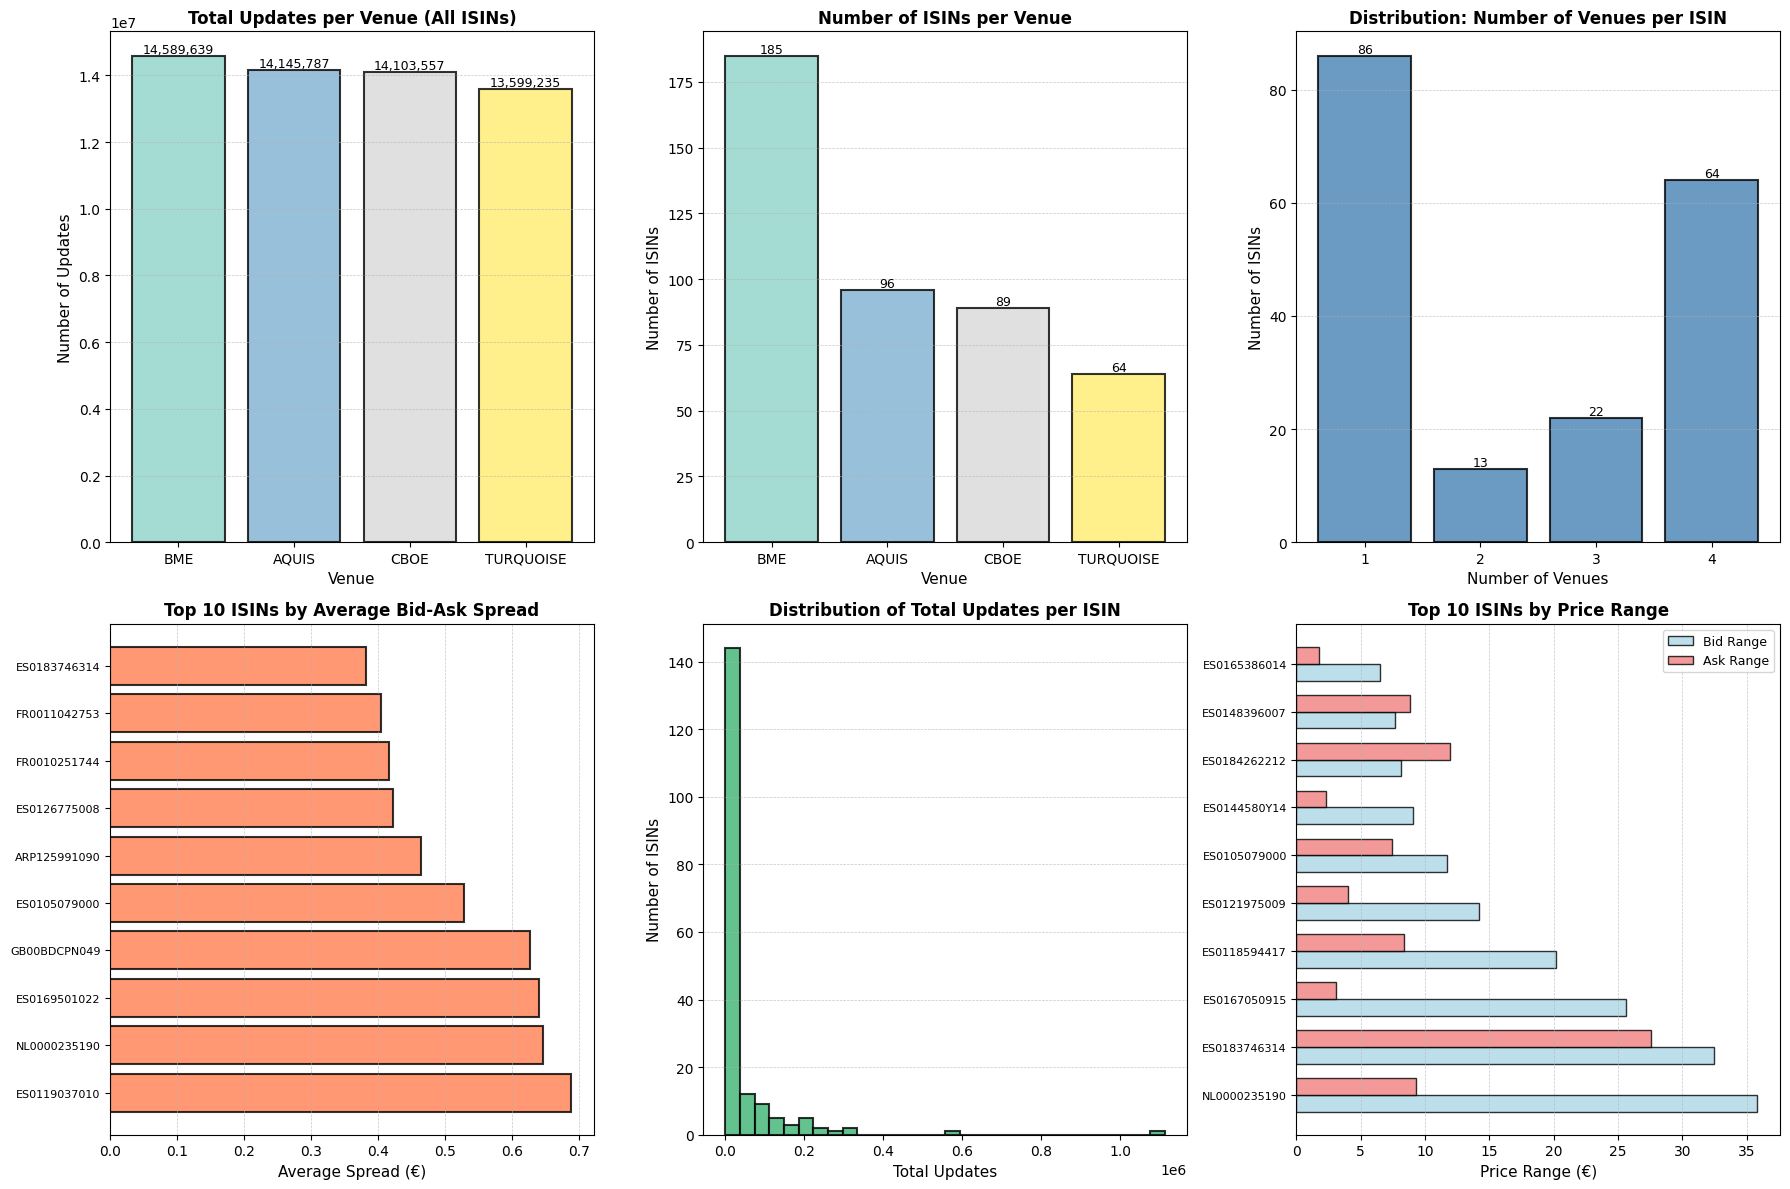


📊 Overall Summary Statistics:
   • Total ISINs analyzed: 185
   • Total venues: 4
   • Venues: BME, AQUIS, CBOE, TURQUOISE

📈 Updates per Venue:
   • BME: 14,589,639 updates across 185 ISINs
   • AQUIS: 14,145,787 updates across 96 ISINs
   • CBOE: 14,103,557 updates across 89 ISINs
   • TURQUOISE: 13,599,235 updates across 64 ISINs

📊 ISIN Statistics:
   • Average number of venues per ISIN: 2.35
   • Average total updates per ISIN: 39451
   • Average bid-ask spread: 0.0793 €

✓ Created summary statistics visualizations


In [13]:
# ============================================================================
# VISUALIZATION 5: Summary Statistics Visualization
# ============================================================================
# This visualization provides an overview of key statistics about the
# consolidated tape data using bar charts and summary metrics.
# ============================================================================

print("=" * 70)
print("VISUALIZATION 5: Summary Statistics Visualization")
print("=" * 70)

# Collect statistics across all ISINs
venue_stats = {}
isin_stats = []

for isin, tape in consolidated_tapes.items():
    bid_cols = [col for col in tape.columns if '_bid' in col]
    ask_cols = [col for col in tape.columns if '_ask' in col]
    venues = [col.replace('_bid', '') for col in bid_cols]
    
    # Count updates per venue
    for venue in venues:
        bid_col = f'{venue}_bid'
        ask_col = f'{venue}_ask'
        
        if venue not in venue_stats:
            venue_stats[venue] = {'updates': 0, 'isins': set()}
        
        if bid_col in tape.columns:
            venue_stats[venue]['updates'] += tape[bid_col].notna().sum()
        if ask_col in tape.columns:
            venue_stats[venue]['updates'] += tape[ask_col].notna().sum()
        
        venue_stats[venue]['isins'].add(isin)
    
    # Calculate statistics for this ISIN
    if len(bid_cols) > 0 and len(ask_cols) > 0:
        # Calculate price ranges
        all_bids = []
        all_asks = []
        for bid_col in bid_cols:
            all_bids.extend(tape[bid_col].dropna().tolist())
        for ask_col in ask_cols:
            all_asks.extend(tape[ask_col].dropna().tolist())
        
        if len(all_bids) > 0 and len(all_asks) > 0:
            min_bid = min(all_bids)
            max_bid = max(all_bids)
            min_ask = min(all_asks)
            max_ask = max(all_asks)
            
            # Calculate average bid-ask spread
            spreads = []
            for venue in venues:
                bid_col = f'{venue}_bid'
                ask_col = f'{venue}_ask'
                if bid_col in tape.columns and ask_col in tape.columns:
                    spread = tape[ask_col] - tape[bid_col]
                    spreads.extend(spread.dropna().tolist())
            
            avg_spread = np.mean(spreads) if len(spreads) > 0 else 0
            
            isin_stats.append({
                'ISIN': isin,
                'Num_Venues': len(venues),
                'Total_Updates': len(tape),
                'Min_Bid': min_bid,
                'Max_Bid': max_bid,
                'Min_Ask': min_ask,
                'Max_Ask': max_ask,
                'Avg_Spread': avg_spread
            })

# Create visualizations
fig = plt.figure(figsize=(18, 12))

# Plot 1: Updates per Venue (Bar Chart)
ax1 = plt.subplot(2, 3, 1)
venues_list = list(venue_stats.keys())
updates_list = [venue_stats[v]['updates'] for v in venues_list]
colors = plt.cm.Set3(np.linspace(0, 1, len(venues_list)))

bars = ax1.bar(venues_list, updates_list, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_title('Total Updates per Venue (All ISINs)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Updates', fontsize=11)
ax1.set_xlabel('Venue', fontsize=11)
ax1.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=9)

# Plot 2: Number of ISINs per Venue
ax2 = plt.subplot(2, 3, 2)
isins_per_venue = [len(venue_stats[v]['isins']) for v in venues_list]
bars2 = ax2.bar(venues_list, isins_per_venue, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_title('Number of ISINs per Venue', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of ISINs', fontsize=11)
ax2.set_xlabel('Venue', fontsize=11)
ax2.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=9)

# Plot 3: Distribution of Number of Venues per ISIN
ax3 = plt.subplot(2, 3, 3)
if isin_stats:
    df_isin_stats = pd.DataFrame(isin_stats)
    venue_counts = df_isin_stats['Num_Venues'].value_counts().sort_index()
    bars3 = ax3.bar(venue_counts.index.astype(str), venue_counts.values, 
                   color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
    ax3.set_title('Distribution: Number of Venues per ISIN', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Number of ISINs', fontsize=11)
    ax3.set_xlabel('Number of Venues', fontsize=11)
    ax3.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
    
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9)

# Plot 4: Average Bid-Ask Spread by ISIN (Top 10)
ax4 = plt.subplot(2, 3, 4)
if isin_stats:
    df_isin_stats = pd.DataFrame(isin_stats)
    top_spreads = df_isin_stats.nlargest(10, 'Avg_Spread')
    bars4 = ax4.barh(range(len(top_spreads)), top_spreads['Avg_Spread'], 
                    color='coral', alpha=0.8, edgecolor='black', linewidth=1.5)
    ax4.set_yticks(range(len(top_spreads)))
    ax4.set_yticklabels([isin[:15] + '...' if len(isin) > 15 else isin 
                        for isin in top_spreads['ISIN']], fontsize=8)
    ax4.set_title('Top 10 ISINs by Average Bid-Ask Spread', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Average Spread (€)', fontsize=11)
    ax4.grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

# Plot 5: Total Updates Distribution
ax5 = plt.subplot(2, 3, 5)
if isin_stats:
    df_isin_stats = pd.DataFrame(isin_stats)
    ax5.hist(df_isin_stats['Total_Updates'], bins=30, color='mediumseagreen', 
            alpha=0.8, edgecolor='black', linewidth=1.5)
    ax5.set_title('Distribution of Total Updates per ISIN', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Number of ISINs', fontsize=11)
    ax5.set_xlabel('Total Updates', fontsize=11)
    ax5.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Plot 6: Price Range Statistics
ax6 = plt.subplot(2, 3, 6)
if isin_stats:
    df_isin_stats = pd.DataFrame(isin_stats)
    # Calculate price range (max - min) for bids and asks
    df_isin_stats['Bid_Range'] = df_isin_stats['Max_Bid'] - df_isin_stats['Min_Bid']
    df_isin_stats['Ask_Range'] = df_isin_stats['Max_Ask'] - df_isin_stats['Min_Ask']
    
    x_pos = np.arange(len(df_isin_stats))
    width = 0.35
    
    # Show top 10 ISINs by bid range
    top_ranges = df_isin_stats.nlargest(10, 'Bid_Range')
    x_pos = np.arange(len(top_ranges))
    
    bars6a = ax6.barh(x_pos - width/2, top_ranges['Bid_Range'], width, 
                     label='Bid Range', color='lightblue', alpha=0.8, edgecolor='black')
    bars6b = ax6.barh(x_pos + width/2, top_ranges['Ask_Range'], width, 
                     label='Ask Range', color='lightcoral', alpha=0.8, edgecolor='black')
    
    ax6.set_yticks(x_pos)
    ax6.set_yticklabels([isin[:12] + '...' if len(isin) > 12 else isin 
                         for isin in top_ranges['ISIN']], fontsize=8)
    ax6.set_title('Top 10 ISINs by Price Range', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Price Range (€)', fontsize=11)
    ax6.legend(loc='best', fontsize=9)
    ax6.grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 Overall Summary Statistics:")
print(f"   • Total ISINs analyzed: {len(consolidated_tapes)}")
print(f"   • Total venues: {len(venue_stats)}")
print(f"   • Venues: {', '.join(venues_list)}")

print("\n📈 Updates per Venue:")
for venue in venues_list:
    print(f"   • {venue}: {venue_stats[venue]['updates']:,} updates across {len(venue_stats[venue]['isins'])} ISINs")

if isin_stats:
    df_isin_stats = pd.DataFrame(isin_stats)
    print(f"\n📊 ISIN Statistics:")
    print(f"   • Average number of venues per ISIN: {df_isin_stats['Num_Venues'].mean():.2f}")
    print(f"   • Average total updates per ISIN: {df_isin_stats['Total_Updates'].mean():.0f}")
    print(f"   • Average bid-ask spread: {df_isin_stats['Avg_Spread'].mean():.4f} €")

print("\n" + "=" * 70)
print("✓ Created summary statistics visualizations")
print("=" * 70)


### Step 3: Signal Generation

- **Arbitrage Condition:** An opportunity exists when Global Max Bid > Global Min Ask.
- **Profit Calc:** (Max Bid - Min Ask) * Min(BidQty, AskQty).
- **Rising Edge:** In a simulation, if an opportunity persists for 1 second (1000 snapshots), you can only trade it *once* (the first time it appears). Ensure you aren't "double counting" the same opportunity. If the opportunity vanishes and quickly reappears you can count it as a new opportunity for simplification.
- **Simplification:** Only look at opportunities between Global Max Bid and Global Min Ask. There might be others at the second or third price levels of the orderbook, but let's make it simple and use only the best Bid Ask of each trading venue.

In [14]:
# Your code here


### Step 4: The "Time Machine" (Latency Simulation)

- In reality, if you see a price at time $T$, you cannot trade until $T + \Delta$.
- **Task:** Simulate execution latencies of [0, 100, 500, 1000, 2000, 3000, 4000, 5000, 10000, 15000, 20000, 30000, 50000, 100000] microseconds
- *Method:* If a signal is detected at T, look up what the profit *actually is* at T + Latency in your dataframe.

In [15]:
# Your code here


## 4. Deliverables & Evaluation

Submit a Jupyter Notebook containing your code and the following analysis:

1. **The "Money Table":** A summary table showing the Total Realized Profit for all processed ISINs at each latency level.
2. **The Decay Chart:** A line chart visualizing how Total Profit (Y-axis) decays as Latency (X-axis) increases.
3. **Top Opportunities:** A list of the Top 5 most profitable ISINs (at 0 latency). **Sanity check these results**—do they look real?

### 1. The "Money Table"

In [16]:
# Your code here


### 2. The Decay Chart

In [17]:
# Your code here


### 3. Top Opportunities

In [18]:
# Your code here


## Grading Rubric (Max 10 Points)

- **5-6 Points (Baseline):** The code runs, correctly calculates the consolidated tape, identifies Bid > Ask opportunities, and estimates theoretical (0 latency) profit.

- **7-8 Points (Robust):** The simulation accurately models latency (using strict time-lookups) and strictly adheres to the vendor's data quality specs.

- **9-10 Points (Expert):** You demonstrate deep understanding of market microstructure. You handle **Market Status** correctly to avoid fake signals, identify anomalies in the instrument list, and handle edge cases around Market Open/Close.